In [139]:
import json
import os

from ml_tools import model_eval, nlp_prep, eda

# Found dataset of NYT Facebook posts

From https://data.world/martinchek/2012-2016-facebook-posts

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Sublime Text told me the encoding was UTF-16 LE with BOM
df = pd.read_csv('data/the-new-york-times-5281959998.csv', encoding='utf_16_le', 
                 engine='python')
df.head()

,id,page_id,name,message,description,caption,post_type,status_type,likes_count,comments_count,shares_count,love_count,wow_count,haha_count,sad_count,thankful_count,angry_count,link,picture,posted_at
0,5281959998_416259568436280,5281959998,Did Barack Obama Save Ohio?,"'There are several pivotal states — Ohio, Flor...",Why the battle to take credit for Ohio’s ever-...,nytimes.com,link,shared_story,413,44,68,0,0,0,0,0,0,http://www.nytimes.com/2012/09/09/magazine/ohi...,https://external.xx.fbcdn.net/safe_image.php?d...,2012-09-08 15:16:55
1,5281959998_268320586619940,5281959998,The Weatherman Is Not a Moron,"In 1940, the chance of an American being kille...",In the hocus-pocus realm of predicting the fut...,nytimes.com,link,shared_story,338,14,78,0,0,0,0,0,0,http://www.nytimes.com/2012/09/09/magazine/the...,https://external.xx.fbcdn.net/safe_image.php?d...,2012-09-08 16:01:13
2,5281959998_467433813289503,5281959998,The Organic Fable,"'Organic has long since become an ideology, th...",A study exposes the hype behind a pseudoscient...,nytimes.com,link,shared_story,812,290,421,0,0,0,0,0,0,http://www.nytimes.com/2012/09/07/opinion/roge...,https://external.xx.fbcdn.net/safe_image.php?d...,2012-09-08 16:44:02
3,5281959998_10150252974589999,5281959998,Timeline Photos,Our special Arts & Leisure section 'The New Se...,NaN,NaN,photo,added_photos,513,17,99,0,0,0,0,0,0,https://www.facebook.com/nytimes/photos/a.2835...,https://scontent.xx.fbcdn.net/v/t1.0-0/s130x13...,2012-09-08 17:32:18
4,5281959998_463550620334374,5281959998,Pot for Parents,'When I’m rolling around the floor with my gig...,"I am a more loving, attentive and patient fath...",nytimes.com,link,shared_story,502,83,170,0,0,0,0,0,0,http://www.nytimes.com/2012/09/08/opinion/how-...,https://external.xx.fbcdn.net/safe_image.php?d...,2012-09-08 19:14:51


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47867 entries, 0 to 47866
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              47867 non-null  object
 1   page_id         47867 non-null  int64 
 2   name            46574 non-null  object
 3   message         46132 non-null  object
 4   description     43512 non-null  object
 5   caption         42892 non-null  object
 6   post_type       47867 non-null  object
 7   status_type     47856 non-null  object
 8   likes_count     47867 non-null  int64 
 9   comments_count  47867 non-null  int64 
 10  shares_count    47867 non-null  int64 
 11  love_count      47867 non-null  int64 
 12  wow_count       47867 non-null  int64 
 13  haha_count      47867 non-null  int64 
 14  sad_count       47867 non-null  int64 
 15  thankful_count  47867 non-null  int64 
 16  angry_count     47867 non-null  int64 
 17  link            47201 non-null  object
 18  pictur

In [5]:
df.describe()

,page_id,likes_count,comments_count,shares_count,love_count,wow_count,haha_count,sad_count,thankful_count,angry_count
count,4.786700e+04,47867.000000,47867.000000,47867.000000,47867.000000,47867.000000,47867.000000,47867.000000,47867.000000,47867.000000
mean,5.281960e+09,1883.853761,179.163599,503.113690,38.096288,14.206301,15.359851,28.534084,0.032653,28.756429
std,0.000000e+00,6223.729785,998.989321,3258.821754,452.819483,151.503261,151.798665,318.864824,1.792674,357.463338
min,5.281960e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.281960e+09,335.000000,33.000000,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.281960e+09,697.000000,73.000000,147.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.281960e+09,1620.000000,173.000000,404.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,5.281960e+09,497519.000000,169805.000000,528856.000000,56070.000000,21121.000000,13214.000000,32316.000000,255.000000,48578.000000


# Gather Initial Article Info via NYT API

In [4]:
rerun_api = False

In [5]:
import requests
import time
import pickle
import gzip
import re

In [6]:
user_home = os.path.expanduser('~')
nyt_token = json.load(open(f'{user_home}/.secret/nytimes_api.json'))

In [9]:
years = [2012, 2013, 2014, 2015, 2016]
months = list(np.arange(1, 13, 1))
months

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Gather initial basic article info for all articles between 2012 and 2016.

In [10]:
if rerun_api:

    base_url = 'https://api.nytimes.com/svc/archive/v1'
    total_count = 0
    articles = []

    for year in years:
        for month in months:
            url = f"{base_url}/{year}/{month}.json?api-key={nyt_token['api_key']}"
            response = requests.get(url)
            resp_dict=json.loads(response.text)

            article_count = resp_dict['response']['meta']['hits']
            print(f"Returned {article_count} articles from {month}, {year}")
            total_count += article_count

            articles.extend(resp_dict['response']['docs'])

            time.sleep(5)
        

In [7]:
# Export all article data to a file (list of dictionaries)
if rerun_api:
    f = gzip.open('nyt_articles_2012_to_2016.pickle.gz','wb')
    pickle.dump(articles, f)
    f.close()
else:
    # load article data from file if not gathering it fresh
    f = gzip.open('data/nyt_articles_2012_to_2016.pickle.gz','rb')
    articles = pickle.load(f)
    f.close()

In [8]:
# Create a dataframe from the NYT articles
df_nyt = pd.DataFrame(articles, columns=articles[0].keys())
df_nyt.head()

,abstract,web_url,snippet,lead_paragraph,print_section,print_page,source,multimedia,headline,keywords,pub_date,document_type,news_desk,section_name,byline,type_of_material,_id,word_count,uri
0,The best New Year’s Day news for Chicago’s spo...,https://www.nytimes.com/2012/01/01/sports/look...,The best New Year’s Day news for Chicago’s spo...,Dan McGrath writes a column for The Chicago Ne...,A,25B,The New York Times,"[{'rank': 0, 'subtype': 'jumbo', 'caption': No...",{'main': 'A Year Full of Missteps Is Finally O...,"[{'name': 'organizations', 'value': 'Chicago C...",2012-01-01T00:00:28+0000,article,National,Sports,"{'original': 'By Dan McGrath', 'person': [{'fi...",News,nyt://article/c304180e-4ab6-5ddb-89dc-8262c0fc...,912,nyt://article/c304180e-4ab6-5ddb-89dc-8262c0fc...
1,The man was preparing to board a flight in Mid...,https://www.nytimes.com/2012/01/01/us/servicem...,The man was preparing to board a flight in Mid...,HOUSTON — A man preparing to board a flight at...,A,19,The New York Times,[],{'main': 'Serviceman Held for Carrying Explosi...,"[{'name': 'subject', 'value': 'Airport Securit...",2012-01-01T00:09:12+0000,article,National,U.S.,"{'original': 'By Manny Fernandez', 'person': [...",News,nyt://article/1d442ebc-7050-5639-98a1-7af4dc9a...,242,nyt://article/1d442ebc-7050-5639-98a1-7af4dc9a...
2,"Setting the scene, Hollywood style, for what c...",https://fifthdown.blogs.nytimes.com/2011/12/31...,"Setting the scene, Hollywood style, for what c...","Yes, the Jets are a long shot to qualify for t...",NaN,NaN,The New York Times,[],{'main': 'Picturing How Ryan Brothers Could Se...,"[{'name': 'subject', 'value': 'Football', 'ran...",2012-01-01T00:14:59+0000,article,,Sports,"{'original': 'By George Bretherton', 'person':...",News,nyt://article/fc3e4b3f-e9ef-50b5-aaeb-0f8da040...,491,nyt://article/fc3e4b3f-e9ef-50b5-aaeb-0f8da040...
3,Experts said the broadcasts were most likely p...,https://thecaucus.blogs.nytimes.com/2011/12/31...,Experts said the broadcasts were most likely p...,DES MOINES — Can they do that?,NaN,NaN,The New York Times,[],{'main': 'Experts Weigh In on Outside Groups’ ...,"[{'name': 'subject', 'value': 'Campaign Financ...",2012-01-01T00:15:52+0000,article,,U.S.,"{'original': 'By Nicholas Confessore', 'person...",News,nyt://article/1bb54d6f-e9c3-5415-a754-cc0a0b4d...,449,nyt://article/1bb54d6f-e9c3-5415-a754-cc0a0b4d...
4,After more than a decade in which San Francisc...,https://www.nytimes.com/2012/01/01/us/an-unlik...,After more than a decade in which San Francisc...,"Susan Beckstead stepped out of her sky-blue, t...",A,25A,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'An Unlikely Group Rebels Against Pre...,"[{'name': 'subject', 'value': 'Historic Buildi...",2012-01-01T00:15:54+0000,article,National,U.S.,"{'original': 'By Matt Smith', 'person': [{'fir...",News,nyt://article/d22bc19c-f690-514c-bb55-d78a9928...,1164,nyt://article/d22bc19c-f690-514c-bb55-d78a9928...


In [13]:
df_nyt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425931 entries, 0 to 425930
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   abstract          425931 non-null  object
 1   web_url           425931 non-null  object
 2   snippet           425931 non-null  object
 3   lead_paragraph    425931 non-null  object
 4   print_section     243058 non-null  object
 5   print_page        243071 non-null  object
 6   source            425931 non-null  object
 7   multimedia        425931 non-null  object
 8   headline          425931 non-null  object
 9   keywords          425931 non-null  object
 10  pub_date          425931 non-null  object
 11  document_type     425931 non-null  object
 12  news_desk         425931 non-null  object
 13  section_name      425931 non-null  object
 14  byline            425931 non-null  object
 15  type_of_material  425931 non-null  object
 16  _id               425931 non-null  obj

In [94]:
df_nyt['keywords'][:5].values

array([list([{'name': 'organizations', 'value': 'Chicago Cubs', 'rank': 1, 'major': 'N'}, {'name': 'organizations', 'value': 'Chicago Bears', 'rank': 2, 'major': 'N'}, {'name': 'organizations', 'value': 'Chicago Bulls', 'rank': 3, 'major': 'N'}, {'name': 'glocations', 'value': 'Chicago (Ill)', 'rank': 4, 'major': 'N'}, {'name': 'persons', 'value': 'Buehrle, Mark', 'rank': 5, 'major': 'N'}, {'name': 'persons', 'value': 'Krzyzewski, Mike', 'rank': 6, 'major': 'N'}, {'name': 'persons', 'value': 'Rose, Derrick', 'rank': 7, 'major': 'N'}, {'name': 'subject', 'value': 'Athletics and Sports', 'rank': 8, 'major': 'N'}]),
       list([{'name': 'subject', 'value': 'Airport Security', 'rank': 1, 'major': 'N'}, {'name': 'organizations', 'value': 'Midland International Corporation', 'rank': 2, 'major': 'N'}, {'name': 'glocations', 'value': 'Houston (Tex)', 'rank': 3, 'major': 'N'}, {'name': 'subject', 'value': 'AIRPORTS', 'rank': 4, 'major': 'N'}, {'name': 'subject', 'value': 'Bombs and Explosives'

# Match facebook posts to NYT articles

## Initial Preprocessing

I learned that I can find the original facebook post by appending the second part of the `id` value after the underscore to this base path: `https://www.facebook.com/nytimes/posts/`.

### Link Expansion

In [106]:
df.loc[(df['link'].isna()==False) & 
                (df['link'].str.contains('nyti.ms', regex=False)), 'link']

1834      http://nyti.ms/YduMRx
1837      http://nyti.ms/WwFEjm
1842      http://nyti.ms/ZiJ0Sb
1844      http://nyti.ms/W8dSHj
1851      http://nyti.ms/XvsHF2
                  ...          
47628    http://nyti.ms/2fvvZck
47635    http://nyti.ms/2e2JGhI
47706    http://nyti.ms/2f8PjIa
47721    http://nyti.ms/2ewyZ5G
47830    http://nyti.ms/2etKx6x
Name: link, Length: 35903, dtype: object

In [183]:
df.loc[(df['link'].isna()==False) & (df['link_expanded'].isna()) & 
               (df['link_expanded_new'].isna()) &
                (df['link'].str.contains('nyti.ms', regex=False))]

,id,page_id,name,message,description,caption,post_type,status_type,likes_count,comments_count,...,link_expanded_new,dupes_on_link,dupe_link_child,dupes_on_desc,dupe_desc_child,dupes_on_name,dupe_name_child,matched_on,link_date,post_date
6010,5281959998_10102352852157271,5281959998,Wedding Album: Valentine's Day,The New York Times Vows section invites reader...,We invite you to tell us the unique ways in wh...,submit.nytimes.com,link,shared_story,1441,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,2014-02-14
15148,5281959998_10150485819419999,5281959998,Turkey Smoked Outdoors,The turkey has left the building.What's your f...,This recipe is by Steven Raichlen and takes 2 ...,cooking.nytimes.com,link,shared_story,250,49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,2014-11-16
15149,5281959998_10150485829769999,5281959998,"Solange Knowles, the younger sister of Beyoncé...","Beyoncé's sister, Solange, gets a ring on it.",Solange Piaget Knowles and Alan Gerard Ferguso...,nytimes.com,link,shared_story,702,87,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,2014-11-16
15150,5281959998_10150485830749999,5281959998,Groups in Ferguson Prepare for Grand Jury Deci...,Demonstrators on Sunday lay in chalk outlines ...,As a grand jury prepared to decide in the comi...,nytimes.com,link,shared_story,771,237,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,2014-11-16
15151,5281959998_10150485840494999,5281959998,One Writer’s Diary for Television Pitch Season,"Before you pitch a TV pilot, it may help to st...",The story of one writer’s path from idea to ne...,nytimes.com,link,shared_story,210,286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,desc,,2014-11-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47628,5281959998_10150951110934999,5281959998,"Safer to Puff, E-Cigarettes Can’t Shake Their ...",Evidence suggests vaping is far less dangerous...,A growing number of experts say that the portr...,nytimes.com,link,shared_story,500,172,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,desc,,2016-11-03
47635,5281959998_10150951251454999,5281959998,Farmers’ Unchecked Crop Burning Fuels India’s ...,India is desperate to reduce air pollution in ...,The burning of straw is a major contributor to...,nytimes.com,link,shared_story,264,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,desc,,2016-11-03
47706,5281959998_10150953813204999,5281959998,Ex-Christie Aides Convicted in George Washingt...,Breaking News: Two former aides to Governor Ch...,"The two defendants, Bridget Anne Kelly and Bil...",nytimes.com,link,shared_story,4368,391,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,2016-11-04
47721,5281959998_10150954183094999,5281959998,Immigrants Living ‘On Pause’ Fear Obama’s Leni...,"At the end of the day, her fear returns: When ...",Two families who came to the United States ill...,nytimes.com,link,shared_story,298,147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,desc,,2016-11-04


In [ ]:
# use urllib to expand URLs, since some are shortened
# code adapted from:
# https://stackoverflow.com/questions/4201062/how-can-i-unshorten-a-url
expanded_link3 = []
session = requests.Session()  # so connections are recycled
count = 0

for i in df.loc[(df['link'].isna()==False) & (df['link_expanded'].isna()==False) & 
                (df['link'].str.contains('nyti.ms', regex=False))].index:
    try:
        resp = session.head(df.at[i, 'link'], allow_redirects=True)
        expanded_link3.append([i, resp.url])
    except:
        print(f"Error at index {i}")
    
    count += 1
    
    if count % 500 == 0:
        print(f"{count} links processed")
        
expanded_link3[:5]

In [14]:
df_expanded1 = pd.DataFrame(expanded_link, columns=['index', 'link_expanded'])
df_expanded1.tail()

,index,link_expanded
35897,47628,http://nyti.ms/2fvvZck
35898,47635,http://nyti.ms/2e2JGhI
35899,47706,http://nyti.ms/2f8PjIa
35900,47721,http://nyti.ms/2ewyZ5G
35901,47830,http://nyti.ms/2etKx6x


In [15]:
df_expanded1.set_index('index', inplace=True)

In [21]:
df_expanded1.loc[~df_expanded1['link_expanded'].str.contains('nytimes.com', 
                                                regex=False)]

,link_expanded
index,
15148,http://nyti.ms/14w5dGz
15149,http://nyti.ms/11bWgjy
15150,http://nyti.ms/1xbvXGQ
15151,http://nyti.ms/1EOBiEj
15152,http://nyti.ms/1H6KuYK
...,...
47628,http://nyti.ms/2fvvZck
47635,http://nyti.ms/2e2JGhI
47706,http://nyti.ms/2f8PjIa


In [22]:
df_expanded1.drop(index=df_expanded1.loc[
    ~df_expanded1['link_expanded'].str.contains('nytimes.com', regex=False)].index,
                  inplace=True)

In [34]:
# concatenate with main df and then I want to save to back it up
df = df.join(df_expanded1, how='left', )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47867 entries, 0 to 47866
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              47867 non-null  object
 1   page_id         47867 non-null  int64 
 2   name            46574 non-null  object
 3   message         46132 non-null  object
 4   description     43512 non-null  object
 5   caption         42892 non-null  object
 6   post_type       47867 non-null  object
 7   status_type     47856 non-null  object
 8   likes_count     47867 non-null  int64 
 9   comments_count  47867 non-null  int64 
 10  shares_count    47867 non-null  int64 
 11  love_count      47867 non-null  int64 
 12  wow_count       47867 non-null  int64 
 13  haha_count      47867 non-null  int64 
 14  sad_count       47867 non-null  int64 
 15  thankful_count  47867 non-null  int64 
 16  angry_count     47867 non-null  int64 
 17  link            47201 non-null  object
 18  pictur

In [36]:
df.loc[df['link_expanded'].isna()==False, 
            ['id', 'link', 'link_expanded']]

,id,link,link_expanded
1834,5281959998_298385756956423,http://nyti.ms/YduMRx,https://www.nytimes.com/2013/03/06/opinion/sho...
1837,5281959998_338711676230154,http://nyti.ms/WwFEjm,https://www.nytimes.com/2013/03/07/technology/...
1842,5281959998_256954574440999,http://nyti.ms/ZiJ0Sb,https://www.nytimes.com/2013/03/07/opinion/coa...
1844,5281959998_280841352048945,http://nyti.ms/W8dSHj,https://www.nytimes.com/2013/03/07/fashion/app...
1851,5281959998_519969881380141,http://nyti.ms/XvsHF2,https://www.nytimes.com/2013/03/09/nyregion/su...
...,...,...,...
15144,5281959998_10150485781054999,http://nyti.ms/1sVukYB,https://www.nytimes.com/2014/11/16/world/mexic...
15145,5281959998_10150485788419999,http://nyti.ms/1EO0Z8a,https://www.nytimes.com/2014/11/14/nyregion/sy...
15146,5281959998_10150485805269999,http://nyti.ms/11bNEth,https://www.nytimes.com/2014/11/16/business/an...
15147,5281959998_10150485814414999,http://nyti.ms/1uBLdf5,https://www.nytimes.com/2014/11/13/science/kee...


In [40]:
# export saved expanded links that we have
df.loc[df['link_expanded'].isna()==False, ['id', 'link', 'link_expanded']]\
    .to_json('data/expanded_links1.json')

In [64]:
# import links expanded from messages
df_message_links = pd.read_json('data/expanded_links_frommessages.json', 
                                dtype='object')
df_message_links.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2217 entries, 1 to 3135
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             2217 non-null   object
 1   link_expanded  2217 non-null   object
dtypes: object(2)
memory usage: 52.0+ KB


In [71]:
# merge message links with main df
df = df.merge(df_message_links, how='left', left_on='id', right_on='id',
                   suffixes=('', '_new'))

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47867 entries, 0 to 47866
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 47867 non-null  object
 1   page_id            47867 non-null  int64 
 2   name               46574 non-null  object
 3   message            46132 non-null  object
 4   description        43512 non-null  object
 5   caption            42892 non-null  object
 6   post_type          47867 non-null  object
 7   status_type        47856 non-null  object
 8   likes_count        47867 non-null  int64 
 9   comments_count     47867 non-null  int64 
 10  shares_count       47867 non-null  int64 
 11  love_count         47867 non-null  int64 
 12  wow_count          47867 non-null  int64 
 13  haha_count         47867 non-null  int64 
 14  sad_count          47867 non-null  int64 
 15  thankful_count     47867 non-null  int64 
 16  angry_count        47867 non-null  int64

## Link Preprocessing

Facebook links start with `http` instead of `https`, so need to adjust that.

Facebook links also have parameters added to the end that don't exist in the NYT links, so I'm going to remove those.

I went back and expanded links, so need to move those from the separate column into a single one.

In [79]:
# replace http with https, since https is used in nytimes links
df['trim_link'] = df['link'].map(lambda x: str.replace(x, 'http:', 'https:') if
                             type(x)==str else '')

In [81]:
# update new expanded links into single trim_link column
df.loc[df['link_expanded'].isna()==False, 'trim_link'] = df.loc[
    df['link_expanded'].isna()==False, 'link_expanded']

df.loc[df['link_expanded_new'].isna()==False,'trim_link'] = df.loc[
    df['link_expanded_new'].isna()==False, 'link_expanded_new']

In [85]:
# pull out the base page link, without any extra & and ?
df['trim_link'] = df['trim_link'].map(
    lambda x: re.search(r"^([^?&]+)", x).group(1) 
                if (type(x)==str and re.search(r"^([^?&]+)", x)) else '')

Are there any types of posts that are less likely to be match-able to articles?

In [86]:
df['status_type'].value_counts()

shared_story            43359
added_photos             2249
added_video              1574
mobile_status_update      654
created_note               11
created_event               9
Name: status_type, dtype: int64

In [17]:
to_explore = ['likes_count', 'comments_count', 'shares_count']
statuses = ['shared_story', 'added_photos', 'added_video', 
            'mobile_status_update']

df.loc[df['status_type'].isin(statuses)]

,id,page_id,name,message,description,caption,post_type,status_type,likes_count,comments_count,...,love_count,wow_count,haha_count,sad_count,thankful_count,angry_count,link,picture,posted_at,trim_link
0,5281959998_416259568436280,5281959998,Did Barack Obama Save Ohio?,"'There are several pivotal states — Ohio, Flor...",Why the battle to take credit for Ohio’s ever-...,nytimes.com,link,shared_story,413,44,...,0,0,0,0,0,0,http://www.nytimes.com/2012/09/09/magazine/ohi...,https://external.xx.fbcdn.net/safe_image.php?d...,2012-09-08 15:16:55,https://www.nytimes.com/2012/09/09/magazine/oh...
1,5281959998_268320586619940,5281959998,The Weatherman Is Not a Moron,"In 1940, the chance of an American being kille...",In the hocus-pocus realm of predicting the fut...,nytimes.com,link,shared_story,338,14,...,0,0,0,0,0,0,http://www.nytimes.com/2012/09/09/magazine/the...,https://external.xx.fbcdn.net/safe_image.php?d...,2012-09-08 16:01:13,https://www.nytimes.com/2012/09/09/magazine/th...
2,5281959998_467433813289503,5281959998,The Organic Fable,"'Organic has long since become an ideology, th...",A study exposes the hype behind a pseudoscient...,nytimes.com,link,shared_story,812,290,...,0,0,0,0,0,0,http://www.nytimes.com/2012/09/07/opinion/roge...,https://external.xx.fbcdn.net/safe_image.php?d...,2012-09-08 16:44:02,https://www.nytimes.com/2012/09/07/opinion/rog...
3,5281959998_10150252974589999,5281959998,Timeline Photos,Our special Arts & Leisure section 'The New Se...,NaN,NaN,photo,added_photos,513,17,...,0,0,0,0,0,0,https://www.facebook.com/nytimes/photos/a.2835...,https://scontent.xx.fbcdn.net/v/t1.0-0/s130x13...,2012-09-08 17:32:18,https://www.facebook.com/nytimes/photos/a.2835...
4,5281959998_463550620334374,5281959998,Pot for Parents,'When I’m rolling around the floor with my gig...,"I am a more loving, attentive and patient fath...",nytimes.com,link,shared_story,502,83,...,0,0,0,0,0,0,http://www.nytimes.com/2012/09/08/opinion/how-...,https://external.xx.fbcdn.net/safe_image.php?d...,2012-09-08 19:14:51,https://www.nytimes.com/2012/09/08/opinion/how...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47862,5281959998_10150958194759999,5281959998,"‘Westworld’ Season 1, Episode 6: The Tipping P...",This week's 'Westworld' gave us the show's mos...,"The world as Maeve understood it is gone, as t...",nytimes.com,link,shared_story,549,37,...,37,9,1,0,0,0,http://www.nytimes.com/2016/11/06/arts/televis...,https://external.xx.fbcdn.net/safe_image.php?d...,2016-11-07 22:40:27,https://www.nytimes.com/2016/11/06/arts/televi...
47863,5281959998_10150958250414999,5281959998,What Ivanka Trump Can’t Sell,“She wants to preach an ideology of female emp...,She has remained loyal to her father. Will tha...,nytimes.com,link,shared_story,3970,621,...,61,58,325,51,0,444,http://www.nytimes.com/2016/11/07/opinion/camp...,https://external.xx.fbcdn.net/safe_image.php?d...,2016-11-07 22:55:00,https://www.nytimes.com/2016/11/07/opinion/cam...
47864,5281959998_10150958439909999,5281959998,"This Time, There Really Is a Hispanic Voter Surge","The Hispanic voter surge is real, and it’s big...",Early voting data unequivocally indicates that...,nytimes.com,link,shared_story,34539,776,...,4473,141,214,4,0,14,http://www.nytimes.com/2016/11/08/upshot/this-...,https://external.xx.fbcdn.net/safe_image.php?d...,2016-11-07 23:26:25,https://www.nytimes.com/2016/11/08/upshot/this...
47865,5281959998_10150958425294999,5281959998,NYT Watching Recommendation of the Day: 'Bob's...,The most passionately pro-weirdo show on telev...,The comedy doesn’t just introduce weirdness bu...,nytimes.com,link,shared_story,4113,428,...,746,2,58,0,0,2,http://www.nytimes.com/watching/recommendation...,https://external.xx.fbcdn.net/safe_image.php?d...,2016-11-07 23:40:00,https://www.nytimes.com/watching/recommendatio...


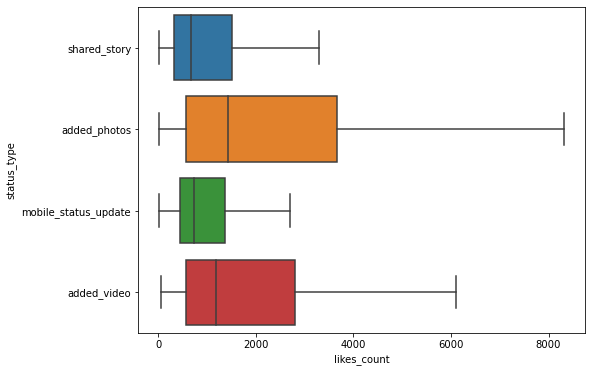

In [18]:
# Distribution for likes
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df.loc[df['status_type'].isin(statuses)], 
             x='likes_count', ax=ax, y='status_type', showfliers=False);

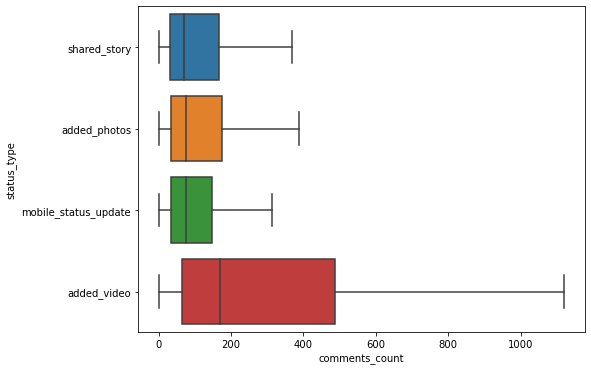

In [19]:
# Distribution for comments
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df.loc[df['status_type'].isin(statuses)], 
             x='comments_count', ax=ax, y='status_type', showfliers=False);

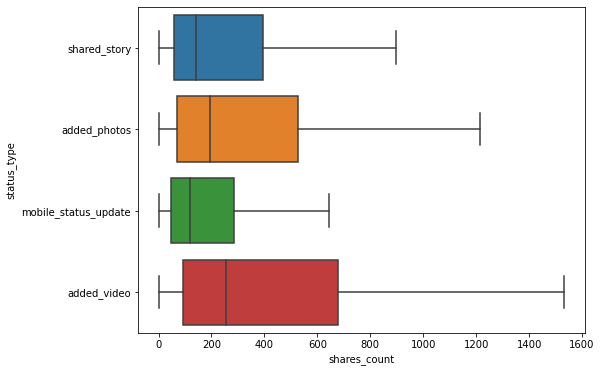

In [20]:
# Distribution for shares
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df.loc[df['status_type'].isin(statuses)], 
             x='shares_count', ax=ax, y='status_type', showfliers=False);

I'm going to stick with just the shared stories for this matching phase. Stand-alone videos and photos do seem to get more engagement, but I don't think I'll be able to match them to actual articles.

In [49]:
# drop facebook updates for updates other than sharing stories
#df.drop(index=df[df['status_type']!='shared_story'].index, inplace=True)

In [50]:
df['status_type'].value_counts()

shared_story            43359
added_photos             2249
added_video              1574
mobile_status_update      654
created_note               11
created_event               9
Name: status_type, dtype: int64

## Review Duplicates

In [87]:
df.loc[df['trim_link']=='', 'trim_link'] = np.nan

In [93]:
# Review duplicates where we have the same link, description, and status_type
df.loc[df.duplicated(subset=['description', 'name', 'message', 'trim_link', 
                             'status_type'], keep=False)]

,id,page_id,name,message,description,caption,post_type,status_type,likes_count,comments_count,...,haha_count,sad_count,thankful_count,angry_count,link,picture,posted_at,link_expanded,trim_link,link_expanded_new
6780,5281959998_10150397071774999,5281959998,NaN,Morning Briefing from NYT Now,NaN,NaN,status,created_note,217,11,...,0,0,0,0,NaN,NaN,2014-04-02 13:24:33,NaN,NaN,NaN
6803,5281959998_10150397304329999,5281959998,NaN,Morning Briefing from NYT Now,NaN,NaN,status,created_note,174,13,...,0,0,0,0,NaN,NaN,2014-04-03 11:34:01,NaN,NaN,NaN
6831,5281959998_10150397660874999,5281959998,NaN,Morning Briefing from NYT Now,NaN,NaN,status,created_note,176,12,...,0,0,0,0,NaN,NaN,2014-04-04 11:36:23,NaN,NaN,NaN
7064,5281959998_10150401300369999,5281959998,Jon Stewart’s Role in Developing Stars,Why the real late-night battle may be between ...,"Under Jon Stewart, “The Daily Show” has become...",nytimes.com,link,shared_story,25,9,...,0,0,0,0,http://nyti.ms/1mhdgee,https://external.xx.fbcdn.net/safe_image.php?d...,2014-04-17 16:18:09,https://www.nytimes.com/2014/04/17/arts/televi...,https://www.nytimes.com/2014/04/17/arts/televi...,NaN
7076,5281959998_10150401364244999,5281959998,Jon Stewart’s Role in Developing Stars,Why the real late-night battle may be between ...,"Under Jon Stewart, “The Daily Show” has become...",nytimes.com,link,shared_story,657,32,...,0,0,0,0,http://nyti.ms/1pejK24,https://external.xx.fbcdn.net/safe_image.php?d...,2014-04-17 21:23:48,https://www.nytimes.com/2014/04/17/arts/televi...,https://www.nytimes.com/2014/04/17/arts/televi...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44317,5281959998_10150882766279999,5281959998,The New York Times Facebook Survey,Please help us at The New York Times by taking...,by The New York Times Research Team,nyt.qualtrics.com,link,shared_story,160,42,...,0,0,0,0,http://nyt.qualtrics.com/SE/?SID=SV_3LfBn9DN7H...,https://external.xx.fbcdn.net/safe_image.php?d...,2016-08-24 15:44:09,NaN,https://nyt.qualtrics.com/SE/,NaN
44332,5281959998_10150882852029999,5281959998,"Exercise Boosts Brain Health, but Is There a D...",Is it possible that exercise could be almost t...,Some research suggests that exercise could imp...,well.blogs.nytimes.com,link,shared_story,153,30,...,1,0,0,0,http://nyti.ms/2bgyOY1,https://external.xx.fbcdn.net/safe_image.php?d...,2016-08-24 21:25:00,NaN,https://nyti.ms/2bgyOY1,NaN
44373,5281959998_10150883703619999,5281959998,"Exercise Boosts Brain Health, but Is There a D...",Is it possible that exercise could be almost t...,Some research suggests that exercise could imp...,well.blogs.nytimes.com,link,shared_story,75,18,...,1,0,0,0,http://nyti.ms/2bgyOY1,https://external.xx.fbcdn.net/safe_image.php?d...,2016-08-25 14:27:01,NaN,https://nyti.ms/2bgyOY1,NaN
46603,5281959998_10150923609324999,5281959998,Timeline Photos,We're fact-checking the presidential debate wi...,NaN,NaN,photo,added_photos,2088,284,...,168,3,0,81,https://www.facebook.com/nytimes/photos/a.2835...,https://scontent.xx.fbcdn.net/v/t1.0-0/s130x13...,2016-10-10 01:58:44,NaN,https://www.nytimes.com/interactive/2016/10/09...,https://www.nytimes.com/interactive/2016/10/09...


In [24]:
df.loc[[47641, 47704]]

,id,page_id,name,message,description,caption,post_type,status_type,likes_count,comments_count,...,love_count,wow_count,haha_count,sad_count,thankful_count,angry_count,link,picture,posted_at,trim_link
47641,5281959998_10150952237769999,5281959998,"Hillary Clinton Still Leads a Tighter Race, Ti...",Breaking News: Hillary Clinton holds a 3-point...,Most voters say that their minds are made up a...,nytimes.com,link,shared_story,6102,634,...,715,31,82,9,0,28,http://www.nytimes.com/2016/11/04/us/politics/...,https://external.xx.fbcdn.net/safe_image.php?d...,2016-11-03 11:03:02,https://www.nytimes.com/2016/11/04/us/politics...
47704,5281959998_10150953685229999,5281959998,Voters Express Disgust Over U.S. Politics in N...,A majority of voters say that neither Hillary ...,Most voters say that their minds are made up a...,nytimes.com,link,shared_story,474,182,...,3,10,5,52,0,4,http://www.nytimes.com/2016/11/04/us/politics/...,https://external.xx.fbcdn.net/safe_image.php?d...,2016-11-04 14:55:00,https://www.nytimes.com/2016/11/04/us/politics...


In [25]:
ex_desc = df.loc[[47641]].values
ex_desc

array([['5281959998_10150952237769999', 5281959998,
        'Hillary Clinton Still Leads a Tighter Race, Times/CBS News Poll Shows',
        'Breaking News: Hillary Clinton holds a 3-point lead over Donald J. Trump in the latest Times/CBS News poll. Most voters say their minds are made up.',
        'Most voters say that their minds are made up and that late revelations about Mrs. Clinton and Donald J. Trump made no significant difference to them.',
        'nytimes.com', 'link', 'shared_story', 6102, 634, 628, 715, 31,
        82, 9, 0, 28,
        'http://www.nytimes.com/2016/11/04/us/politics/hillary-clinton-donald-trump-poll.html?smid=fb-nytimes&smtyp=cur',
        'https://external.xx.fbcdn.net/safe_image.php?d=AQBMxkLxy577UjpI&w=130&h=130&url=https%3A%2F%2Fstatic01.nyt.com%2Fimages%2F2016%2F11%2F03%2Fus%2F04poll1%2F04poll1-facebookJumbo.jpg&cfs=1&sx=224&sy=0&sw=550&sh=550',
        '2016-11-03 11:03:02',
        'https://www.nytimes.com/2016/11/04/us/politics/hillary-clinton-dona

In [26]:
df_nyt.loc[[416125]].values

array([['Most voters say that their minds are made up and that late revelations about Mrs. Clinton and Donald J. Trump made no significant difference to them.',
        'https://www.nytimes.com/2016/11/04/us/politics/hillary-clinton-donald-trump-poll.html',
        'Most voters say that their minds are made up and that late revelations about Mrs. Clinton and Donald J. Trump made no significant difference to them.',
        'An overwhelming majority of voters are disgusted by the state of American politics, and many harbor doubts that either major-party nominee can unite the country after a historically ugly presidential campaign, according to the final pre-election New York Times/CBS News Poll.',
        'A', '1', 'The New York Times',
        list([{'rank': 0, 'subtype': 'thumbnail', 'caption': None, 'credit': None, 'type': 'image', 'url': 'images/2016/11/03/us/04poll1/04poll1-thumbStandard.jpg', 'height': 75, 'width': 75, 'subType': 'thumbnail', 'crop_name': 'thumbStandard', 'legacy'

In [27]:
df.loc[[47641, 47704]].values

array([['5281959998_10150952237769999', 5281959998,
        'Hillary Clinton Still Leads a Tighter Race, Times/CBS News Poll Shows',
        'Breaking News: Hillary Clinton holds a 3-point lead over Donald J. Trump in the latest Times/CBS News poll. Most voters say their minds are made up.',
        'Most voters say that their minds are made up and that late revelations about Mrs. Clinton and Donald J. Trump made no significant difference to them.',
        'nytimes.com', 'link', 'shared_story', 6102, 634, 628, 715, 31,
        82, 9, 0, 28,
        'http://www.nytimes.com/2016/11/04/us/politics/hillary-clinton-donald-trump-poll.html?smid=fb-nytimes&smtyp=cur',
        'https://external.xx.fbcdn.net/safe_image.php?d=AQBMxkLxy577UjpI&w=130&h=130&url=https%3A%2F%2Fstatic01.nyt.com%2Fimages%2F2016%2F11%2F03%2Fus%2F04poll1%2F04poll1-facebookJumbo.jpg&cfs=1&sx=224&sy=0&sw=550&sh=550',
        '2016-11-03 11:03:02',
        'https://www.nytimes.com/2016/11/04/us/politics/hillary-clinton-dona

I'm not sure I can just drop these completely... It looks like maybe the duplicates could represent some experimentation with framing the story differently to capture the attention of audiences better, and it's possible this resulted in significantly different numbers of comments and likes. It's also possible that the change is due to going with an initial headline for breaking news, and changing it later. The first example was a breaking news story at first, and it was also related to results of a poll, from which many conclusions could be drawn. Maybe they just needed more time to tease additional insights out of the story.

What I would like to do is mark these duplicates so I can try to match the API articles based on just one copy, and then I will need to go back and take a look at the details to decide which version should actually be kept. 

Perhaps both, since they will have different message values and different numbers of comments and likes, so we could do a direct comparison to see which did better. Maybe the second post could be in the test set?

In [94]:
# populate 'dupes_on' column for all copies indicating how duplicate status
# was determined. `link` means these are duplicates based on the link
df.loc[df.duplicated(subset=['trim_link', 'status_type'], keep=False), 
       'dupes_on_link'] = 1

# populate `dupe_child` column for all but the first occurences
df.loc[df.duplicated(subset=['trim_link', 'status_type'], keep='first'), 
       'dupe_link_child'] = 1

In [95]:
# identify duplicates based on description only, since I want to try to
# use that to join with nyt articles
df.loc[(df.duplicated(subset=['description'], keep=False)) &
        (df['description'].isna()==False), 'dupes_on_desc'] = 1

df.loc[(df.duplicated(subset=['description'], keep='first')) &
       (df['description'].isna()==False), 'dupe_desc_child'] = 1

In [96]:
# identify duplicates based on name
df.loc[(df.duplicated(subset=['name'], keep=False)) &
        (df['name'].isna()==False), 'dupes_on_name'] = 1

df.loc[(df.duplicated(subset=['name'], keep='first')) &
       (df['name'].isna()==False), 'dupe_name_child'] = 1

In [97]:
df.loc[(df['dupes_on_link']==1) | 
       (df['dupes_on_desc']==1) | 
       (df['dupes_on_name']==1)]

,id,page_id,name,message,description,caption,post_type,status_type,likes_count,comments_count,...,posted_at,link_expanded,trim_link,link_expanded_new,dupes_on_link,dupe_link_child,dupes_on_desc,dupe_desc_child,dupes_on_name,dupe_name_child
3,5281959998_10150252974589999,5281959998,Timeline Photos,Our special Arts & Leisure section 'The New Se...,NaN,NaN,photo,added_photos,513,17,...,2012-09-08 17:32:18,NaN,https://www.facebook.com/nytimes/photos/a.2835...,NaN,NaN,NaN,NaN,NaN,1.0,NaN
5,5281959998_10150253031069999,5281959998,Timeline Photos,During a surprise visit to Gators Dockside bar...,NaN,NaN,photo,added_photos,9012,594,...,2012-09-09 01:36:15,NaN,https://thecaucus.blogs.nytimes.com/2012/09/08...,https://thecaucus.blogs.nytimes.com/2012/09/08...,NaN,NaN,NaN,NaN,1.0,1.0
13,5281959998_10150253189039999,5281959998,Timeline Photos,President Obama got a huge lift—literally — fr...,NaN,NaN,photo,added_photos,16918,1415,...,2012-09-09 21:43:46,NaN,https://thecaucus.blogs.nytimes.com/2012/09/09...,https://thecaucus.blogs.nytimes.com/2012/09/09...,NaN,NaN,NaN,NaN,1.0,1.0
14,5281959998_10150253207659999,5281959998,Timeline Photos,Serena Williams defeated Victoria Azarenka to ...,NaN,NaN,photo,added_photos,7629,353,...,2012-09-09 23:18:27,NaN,https://archive.nytimes.com/www.nytimes.com/in...,https://archive.nytimes.com/www.nytimes.com/in...,NaN,NaN,NaN,NaN,1.0,1.0
20,5281959998_353360298082368,5281959998,"Teacher Strike Begins in Chicago, Amid Signs T...","Teachers in Chicago Public Schools, the nation...","As about 350,000 students got an unexpected da...",nytimes.com,link,shared_story,187,19,...,2012-09-10 15:36:47,NaN,https://www.nytimes.com/2012/09/11/education/t...,NaN,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47840,5281959998_10150957971334999,5281959998,The New York Times - Theater,"We're with Mike Daisey, who is performing a po...","Learn about the making of Donald J. Trump, as ...",NaN,video,shared_story,229,59,...,2016-11-07 16:31:11,NaN,https://www.facebook.com/nytimestheater/videos...,NaN,NaN,NaN,NaN,NaN,1.0,1.0
47845,5281959998_10150958061204999,5281959998,Nicholas Kristof,"Nicholas Kristof, a columnist for The New York...",Our last Facebook Live before the election! Ch...,NaN,video,shared_story,144,40,...,2016-11-07 17:45:15,NaN,https://www.facebook.com/kristof/videos/101545...,NaN,NaN,NaN,NaN,NaN,1.0,1.0
47847,5281959998_10150958085764999,5281959998,The New York Times - Well - Health,Lauren Hard and Paul Moon of The New York Time...,"We're at Pure Yoga with Sarah Attia, founder o...",NaN,video,shared_story,70,6,...,2016-11-07 18:06:08,NaN,https://www.facebook.com/WellNYT/videos/116561...,NaN,NaN,NaN,NaN,NaN,1.0,1.0
47850,5281959998_10150958116574999,5281959998,Two Men Entered the Ring for Their First Profe...,A reason to binge on some of our best long rea...,Anthony Taylor had won the fight. And the fall...,nytimes.com,link,shared_story,87,10,...,2016-11-07 19:10:00,NaN,https://www.nytimes.com/2016/03/28/sports/boxi...,NaN,NaN,NaN,1.0,1.0,1.0,1.0


I can now try to join the facebook posts to articles using link, description, and name, and I can isolate only the posts that have no duplicates in each joining column.

## Exact join on link

In [98]:
len(df.loc[df['dupes_on_link'].isna()])

44156

In [102]:
# Test joining together the matches based on trimmed link, starting with only
# facebook posts that are not duplicated based on link
df_link_matches = pd.merge(left=df.loc[df['dupes_on_link'].isna()], 
                           right=df_nyt, 
                           how='inner', 
                           left_on='trim_link', 
                           right_on='web_url',
                           suffixes=('_nyt', '_nyt'))
df_link_matches.head()

,id,page_id,name,message,description,caption,post_type,status_type,likes_count,comments_count,...,keywords,pub_date,document_type,news_desk,section_name,byline,type_of_material,_id,word_count,uri
0,5281959998_416259568436280,5281959998,Did Barack Obama Save Ohio?,"'There are several pivotal states — Ohio, Flor...",Why the battle to take credit for Ohio’s ever-...,nytimes.com,link,shared_story,413,44,...,"[{'name': 'glocations', 'value': 'Ohio', 'rank...",2012-09-05T09:00:27+0000,article,Magazine,Magazine,"{'original': 'By Matt Bai', 'person': [{'first...",News,nyt://article/b122515f-2281-5ca8-8749-7a64f317...,7113,nyt://article/b122515f-2281-5ca8-8749-7a64f317...
1,5281959998_268320586619940,5281959998,The Weatherman Is Not a Moron,"In 1940, the chance of an American being kille...",In the hocus-pocus realm of predicting the fut...,nytimes.com,link,shared_story,338,14,...,"[{'name': 'persons', 'value': 'Richardson, Lew...",2012-09-07T09:00:29+0000,article,Magazine,Magazine,"{'original': 'By Nate Silver', 'person': [{'fi...",News,nyt://article/c45ee260-62ac-52cf-8937-29d1f731...,3915,nyt://article/c45ee260-62ac-52cf-8937-29d1f731...
2,5281959998_463550620334374,5281959998,Pot for Parents,'When I’m rolling around the floor with my gig...,"I am a more loving, attentive and patient fath...",nytimes.com,link,shared_story,502,83,...,"[{'name': 'subject', 'value': 'Medical Marijua...",2012-09-07T23:53:19+0000,article,OpEd,Opinion,"{'original': 'By Mark Wolfe', 'person': [{'fir...",Op-Ed,nyt://article/18ecc9e3-6e52-5c51-a7c2-9a788727...,855,nyt://article/18ecc9e3-6e52-5c51-a7c2-9a788727...
3,5281959998_10150253031069999,5281959998,Timeline Photos,During a surprise visit to Gators Dockside bar...,NaN,NaN,photo,added_photos,9012,594,...,"[{'name': 'subject', 'value': 'Presidential El...",2012-09-09T00:02:44+0000,article,,U.S.,"{'original': 'By Helene Cooper', 'person': [{'...",News,nyt://article/686b0747-bbe4-5436-86ad-ada41713...,114,nyt://article/686b0747-bbe4-5436-86ad-ada41713...
4,5281959998_437214569655310,5281959998,Debt Collectors Cashing In on Student Loan Rou...,Quotation of the Day: 'You are going to pay it...,The Department of Education last year paid $1....,nytimes.com,link,shared_story,260,74,...,"[{'name': 'subject', 'value': 'Series', 'rank'...",2012-09-08T22:17:12+0000,article,Business,Business Day,"{'original': 'By Andrew Martin', 'person': [{'...",News,nyt://article/28e0313f-8660-56b8-9ed8-db9be898...,2508,nyt://article/28e0313f-8660-56b8-9ed8-db9be898...


In [103]:
# Check if more than one NYT article matched with a single facebook link
print(len(df_link_matches[df_link_matches.duplicated(subset=['id'])]))
df_link_matches[df_link_matches.duplicated(subset=['id'], keep=False)]


3


,id,page_id,name,message,description,caption,post_type,status_type,likes_count,comments_count,...,keywords,pub_date,document_type,news_desk,section_name,byline,type_of_material,_id,word_count,uri
1498,5281959998_350894045015656,5281959998,Q. and A. on the Papal Transition,White smoke poured from a chimney atop the Sis...,Times reporters covering the papal transition ...,thelede.blogs.nytimes.com,link,shared_story,813,102,...,[],2013-03-11T20:44:42+0000,article,,Blogs,"{'original': 'By THE NEW YORK TIMES', 'person'...",News,nyt://article/8c62f483-ffe2-5091-865c-77d2a0f9...,1915,nyt://article/8c62f483-ffe2-5091-865c-77d2a0f9...
1499,5281959998_350894045015656,5281959998,Q. and A. on the Papal Transition,White smoke poured from a chimney atop the Sis...,Times reporters covering the papal transition ...,thelede.blogs.nytimes.com,link,shared_story,813,102,...,"[{'name': 'subject', 'value': 'Cardinals (Roma...",2013-03-11T20:44:42+0000,article,,Blogs,"{'original': 'By The New York Times', 'person'...",News,nyt://article/c3d1cb31-6132-5868-81ca-911d05c2...,1915,nyt://article/c3d1cb31-6132-5868-81ca-911d05c2...
11899,5281959998_10150605618964999,5281959998,Timeline Photos,Whimsical photos from the back roads of Americ...,NaN,NaN,photo,added_photos,907,24,...,[],2015-06-15T07:00:39+0000,article,,Multimedia/Photos,"{'original': 'By RENA SILVERMAN', 'person': [{...",News,nyt://article/8d01db56-a3ce-5242-92fa-cd2f5a93...,825,nyt://article/8d01db56-a3ce-5242-92fa-cd2f5a93...
11900,5281959998_10150605618964999,5281959998,Timeline Photos,Whimsical photos from the back roads of Americ...,NaN,NaN,photo,added_photos,907,24,...,"[{'name': 'subject', 'value': 'Photography', '...",2015-06-15T07:00:39+0000,article,,Crosswords & Games,"{'original': 'By Rena Silverman', 'person': [{...",News,nyt://article/bad09ab6-18e7-5ad6-aea6-d56d46f3...,825,nyt://article/bad09ab6-18e7-5ad6-aea6-d56d46f3...
11935,5281959998_10150608613634999,5281959998,Marc Maron Discusses His Podcast Interview Wit...,"Marc Maron, the idiosyncratic, inquisitive an...",The comedian interviewed the commander in chie...,artsbeat.blogs.nytimes.com,link,shared_story,415,24,...,"[{'name': 'subject', 'value': 'Podcasts', 'ran...",2015-06-19T20:10:35+0000,article,Culture,Arts,"{'original': 'By Dave Itzkoff', 'person': [{'f...",News,nyt://article/807c0c24-e084-54cf-8564-27b2d2c8...,1667,nyt://article/807c0c24-e084-54cf-8564-27b2d2c8...
11936,5281959998_10150608613634999,5281959998,Marc Maron Discusses His Podcast Interview Wit...,"Marc Maron, the idiosyncratic, inquisitive an...",The comedian interviewed the commander in chie...,artsbeat.blogs.nytimes.com,link,shared_story,415,24,...,[],2015-06-19T20:10:35+0000,article,,Crosswords & Games,"{'original': 'By DAVE ITZKOFF', 'person': [{'f...",News,nyt://article/8d1285ea-4f3a-57d0-8c0b-8923ac69...,1667,nyt://article/8d1285ea-4f3a-57d0-8c0b-8923ac69...


In [104]:
# Check for duplicate NYT articles that were matched with Facebook posts
print(len(df_link_matches[df_link_matches.duplicated(subset=['_id'])]))
df_link_matches[df_link_matches.duplicated(subset=['_id'], keep=False)]

126


,id,page_id,name,message,description,caption,post_type,status_type,likes_count,comments_count,...,keywords,pub_date,document_type,news_desk,section_name,byline,type_of_material,_id,word_count,uri
926,5281959998_10150275554924999,5281959998,Timeline Photos,It's official: 2012 was the hottest year ever ...,NaN,NaN,photo,added_photos,843,139,...,"[{'name': 'persons', 'value': 'Gillis, Justin'...",2013-01-08T18:33:45+0000,article,National,Science,"{'original': 'By Justin Gillis', 'person': [{'...",News,nyt://article/6b759bc5-e3df-50be-b246-3050045c...,903,nyt://article/6b759bc5-e3df-50be-b246-3050045c...
927,5281959998_473125349417587,5281959998,Not Even Close: 2012 Was Hottest Ever in U.S.,Quotation of the Day: 'The heat was remarkable...,Last year’s 55.3 degree average topped the pre...,nytimes.com,link,shared_story,212,25,...,"[{'name': 'persons', 'value': 'Gillis, Justin'...",2013-01-08T18:33:45+0000,article,National,Science,"{'original': 'By Justin Gillis', 'person': [{'...",News,nyt://article/6b759bc5-e3df-50be-b246-3050045c...,903,nyt://article/6b759bc5-e3df-50be-b246-3050045c...
938,5281959998_492250480813643,5281959998,Voters Shut Out Hall of Fame Candidates,In perhaps the most resounding referendum on t...,"For the first time since 1996, no players rece...",nytimes.com,link,shared_story,345,74,...,"[{'name': 'persons', 'value': 'Kepner, Tyler',...",2013-01-09T19:08:47+0000,article,Sports,Sports,"{'original': 'By Tyler Kepner', 'person': [{'f...",News,nyt://article/6471d8a1-5da7-51eb-96c7-e342ca06...,1345,nyt://article/6471d8a1-5da7-51eb-96c7-e342ca06...
939,5281959998_10150275861879999,5281959998,Timeline Photos,The front page of the Sports Section welcomes ...,NaN,NaN,photo,added_photos,279,23,...,"[{'name': 'persons', 'value': 'Kepner, Tyler',...",2013-01-09T19:08:47+0000,article,Sports,Sports,"{'original': 'By Tyler Kepner', 'person': [{'f...",News,nyt://article/6471d8a1-5da7-51eb-96c7-e342ca06...,1345,nyt://article/6471d8a1-5da7-51eb-96c7-e342ca06...
1585,5281959998_10150293984859999,5281959998,Timeline Photos,"“Our sons and daughters are not born to hate, ...",NaN,NaN,photo,added_photos,3694,270,...,"[{'name': 'persons', 'value': 'Obama, Barack',...",2013-03-22T09:42:45+0000,article,Foreign,World,{'original': 'By Jodi Rudoren and Mark Landler...,News,nyt://article/91c0df18-6cb0-586e-842d-35fc28da...,1360,nyt://article/91c0df18-6cb0-586e-842d-35fc28da...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14302,5281959998_10150946496639999,5281959998,Arrests and Violence at Dakota Pipeline,The tension between law enforcement and protes...,NaN,NaN,video,added_video,762,234,...,"[{'name': 'glocations', 'value': 'Standing Roc...",2016-10-28T16:37:15+0000,article,National,U.S.,{'original': 'By Sue Skalicky and Monica Davey...,News,nyt://article/cd7fec00-241a-56f9-b56e-1cdc08c2...,693,nyt://article/cd7fec00-241a-56f9-b56e-1cdc08c2...
14525,5281959998_10150955949149999,5281959998,The New York Times to Offer Open Access on Web...,We're giving everyone unlimited access to The ...,The New York Times is inviting readers to take...,nytimes.com,link,shared_story,28337,602,...,"[{'name': 'subject', 'value': 'Presidential El...",2016-11-03T20:58:39+0000,article,NewsDesk,U.S.,"{'original': '', 'person': [], 'organization':...",News,nyt://article/30fb1562-4bd8-5cda-8c44-d10f40d2...,350,nyt://article/30fb1562-4bd8-5cda-8c44-d10f40d2...
14526,5281959998_10150957229929999,5281959998,Timeline Photos,Election week is here. Enjoy unlimited access ...,NaN,NaN,photo,added_photos,1196,532,...,"[{'name': 'subject', 'value': 'Presidential El...",2016-11-03T20:58:39+0000,article,NewsDesk,U.S.,"{'original': '', 'person': [], 'organization':...",News,nyt://article/30fb1562-4bd8-5cda-8c44-d10f40d2...,350,nyt://article/30fb1562-4bd8-5cda-8c44-d10f40d2...
14543,5281959998_10150957315964999,5281959998,Where Burning Effigies (Not Just Guy Fawkes’s)...,Donald Trump and Theresa May were burned in ef...,"Bonfires, blaz

In [105]:
# update which facebook posts have been joined up, so can run further joins
# on different criteria, and only on those that aren't yet matched
df.loc[df['id'].isin(df_link_matches['id'].values), 'matched_on'] = 'link'
len(df[df['matched_on']=='link'])

14577

## Exact join on description

In [106]:
# pull only posts without duplicate descriptions, and where the posts
# haven't already been matched with an article
len(df.loc[(df['dupes_on_desc'].isna()) & (df['matched_on'].isna())])

29545

In [107]:
# Test joining together the matches based on description and snippet
df_desc_matches = pd.merge(left=df.loc[(df['dupes_on_desc'].isna()) 
                                       & (df['matched_on'].isna())], 
                           right=df_nyt, 
                           how='inner', 
                           left_on='description', 
                           right_on='snippet',
                           suffixes=('_nyt', '_nyt'))
len(df_desc_matches)

18682

In [108]:
# Check if more than one NYT article matched with a single facebook link
print(len(df_desc_matches[df_desc_matches.duplicated(subset=['id'])]))
df_desc_matches[df_desc_matches.duplicated(subset=['id'], keep=False)]


468


,id,page_id,name,message,description,caption,post_type,status_type,likes_count,comments_count,...,keywords,pub_date,document_type,news_desk,section_name,byline,type_of_material,_id,word_count,uri
75,5281959998_10150299457829999,5281959998,Updates on Aftermath of Boston Marathon Explos...,'Something is wrong. They have been framed.' R...,The Lede is following the aftermath of Monday’...,thelede.blogs.nytimes.com,link,shared_story,342,136,...,"[{'name': 'subject', 'value': 'Boston Marathon...",2013-04-18T14:35:07+0000,article,,Blogs,"{'original': 'By Christine Hauser, Jennifer Pr...",News,nyt://article/8d63a22b-24a5-5527-a7b2-2888674d...,4192,nyt://article/8d63a22b-24a5-5527-a7b2-2888674d...
76,5281959998_10150299457829999,5281959998,Updates on Aftermath of Boston Marathon Explos...,'Something is wrong. They have been framed.' R...,The Lede is following the aftermath of Monday’...,thelede.blogs.nytimes.com,link,shared_story,342,136,...,"[{'name': 'subject', 'value': 'Boston Marathon...",2013-04-19T10:25:31+0000,article,,Blogs,"{'original': 'By The New York Times', 'person'...",News,nyt://article/c71f2857-d9ff-50c1-9cc7-3baf14e5...,13612,nyt://article/c71f2857-d9ff-50c1-9cc7-3baf14e5...
97,5281959998_10150306238154999,5281959998,Video: Bill Cunningham | Full Bloom,"Bill Cunningham, inspired by the four-foot-lon...","A focus of fashion is the length of the leg, s...",nytimes.com,link,shared_story,175,3,...,"[{'name': 'subject', 'value': 'Fashion and App...",2013-05-18T02:48:10+0000,multimedia,,Fashion & Style,"{'original': 'Joanna Nikas', 'person': [{'firs...",Video,nyt://video/854ae85f-5a35-5e2c-ba51-107b1567c087,0,nyt://video/854ae85f-5a35-5e2c-ba51-107b1567c087
98,5281959998_10150306238154999,5281959998,Video: Bill Cunningham | Full Bloom,"Bill Cunningham, inspired by the four-foot-lon...","A focus of fashion is the length of the leg, s...",nytimes.com,link,shared_story,175,3,...,"[{'name': 'subject', 'value': 'Fashion and App...",2013-05-20T16:54:55+0000,article,,Style,"{'original': 'By Bill Cunningham', 'person': [...",News,nyt://article/c4185b01-90be-5fbb-85d8-1f6f7d74...,47,nyt://article/c4185b01-90be-5fbb-85d8-1f6f7d74...
108,5281959998_10150309977124999,5281959998,Video: Escape From North Korea,'The government doesn't give us a thing but th...,A smuggler named Dragon attempts to guide Nort...,nytimes.com,link,shared_story,386,20,...,"[{'name': 'glocations', 'value': 'North Korea'...",2013-06-06T01:05:08+0000,multimedia,Opinion,Opinion,"{'original': 'Ann Shin', 'person': [{'firstnam...",Video,nyt://video/786833f5-cd66-5444-9cdf-75707417146a,0,nyt://video/786833f5-cd66-5444-9cdf-75707417146a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18212,5281959998_10150903747994999,5281959998,9 New Books We Recommend This Week,Time to dig into the meaty books of fall.,Suggested reading by the editors of The New Yo...,nytimes.com,link,shared_story,616,31,...,"[{'name': 'subject', 'value': 'Books and Liter...",2016-09-29T18:44:09+0000,article,BookReview,Books,"{'original': '', 'person': [], 'organization':...",News,nyt://article/5f01ebd6-67f0-5fc9-bc7e-bd1ba449...,710,nyt://article/5f01ebd6-67f0-5fc9-bc7e-bd1ba449...
18264,5281959998_10150907252139999,5281959998,The Many Sad Fates of Mr. Toledano,Phillip Toledano was terrified of growing old....,Phillip Toledano was terrified of growing old....,nytimes.com,link,shared_story,1449,122,...,"[{'name': 'subject', 'value': 'Documentary Fil...",2016-09-20T20:08:21+0000,article,OpEd,Opinion,"{'original': 'By Joshua Seftel', 'person': [{'...",Op-Ed,nyt://article/6ea8cbcd-bcb3-5d8c-b178-641c6ef2...,492,nyt://article/6ea8cbcd-bcb3-5d8c-b178-641c6ef2...
18265,5281959998_10150907252139999,5281959998,The Many Sad Fates of Mr. Toledano,Phillip Toledano was terrified of growing old....,Phillip Toledano was terrified of growing old....,nytimes.com,link,shared_story,1449,122,...,"[{'name': 'persons', 'value': 'Toledano, Phill...",2016-09-20T20:09:42+0000,multimed

Definitely more duplicates here. It looks like they're primarily due to there being a video version and a news/written version of certain pieces.

Looking at a few examples, can I easily tell whether the facebook post is for one or the other? I may need to write my own custom deduplication script to identify the best one to keep, especially if only certain ones will have comments I can use to compare to facebook likes and shares.

So the video link here https://www.nytimes.com/video/opinion/100000004653100/the-many-sad-fates-of-mr-toledano.html is the video only, and it doesn't include any comments listed on the page.

But the article link to the text description does include comments https://www.nytimes.com/2016/09/20/opinion/the-many-sad-fates-of-mr-toledano.html.

What I may do is just keep both copies in for now, since I can't know for sure which, if either, will have comments I can pull via APIs or scrape from the website. I'll perform that step knowing there will be some duplicates, and then keep whichever version got comments, if one did.

In [110]:
# Check for duplicate NYT articles that were matched with Facebook posts
print(len(df_desc_matches[df_desc_matches.duplicated(subset=['_id'])]))
df_desc_matches[df_desc_matches.duplicated(subset=['_id'], keep=False)]

0


,id,page_id,name,message,description,caption,post_type,status_type,likes_count,comments_count,...,keywords,pub_date,document_type,news_desk,section_name,byline,type_of_material,_id,word_count,uri


In [111]:
# update which facebook posts have been joined up, so can run further joins
# on different criteria, and only on those that aren't yet matched
df.loc[df['id'].isin(df_desc_matches['id'].values), 'matched_on'] = 'desc'
len(df[df['matched_on']=='desc'])

18214

In [112]:
# how many unmatched are left?
len(df[df['matched_on'].isna()])

15076

In [113]:
# how many unmatched are not duplicates on something?
len(df[(df['matched_on'].isna()) & (
    ((df['dupes_on_link'].isna()) & 
    (df['dupes_on_desc'].isna()) & 
    (df['dupes_on_name'].isna()))
)])


7644

In [114]:
df[(df['matched_on'].isna()) & (
    ((df['dupes_on_link'].isna()) & 
    (df['dupes_on_desc'].isna()) & 
    (df['dupes_on_name'].isna()))
)]

,id,page_id,name,message,description,caption,post_type,status_type,likes_count,comments_count,...,link_expanded,trim_link,link_expanded_new,dupes_on_link,dupe_link_child,dupes_on_desc,dupe_desc_child,dupes_on_name,dupe_name_child,matched_on
2,5281959998_467433813289503,5281959998,The Organic Fable,"'Organic has long since become an ideology, th...",A study exposes the hype behind a pseudoscient...,nytimes.com,link,shared_story,812,290,...,NaN,https://www.nytimes.com/2012/09/07/opinion/rog...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,5281959998_269424823169279,5281959998,Jessica Chastain TimesTalks Live Webcast,NaN,Watch the free livestream here: http://nyti.ms...,Jessica Chastain TimesTalks Live Webcast,event,created_event,51,7,...,NaN,https://www.facebook.com/events/269424823169279/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,5281959998_380912158643622,5281959998,'The Schools for Tomorrow' Live Webcast,NaN,Watch the free livestream of our second annual...,'The Schools for Tomorrow' Live Webcast,event,created_event,49,7,...,NaN,https://www.facebook.com/events/380912158643622/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,5281959998_224679674326401,5281959998,Video: Patriot Game,'POWER YOUR PRESIDENT TO WINNING. USE MANY GOO...,The Gregory Brothers present a video game-insp...,nytimes.com,link,shared_story,178,38,...,NaN,https://www.nytimes.com/video/2012/09/16/opini...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,5281959998_529920297023044,5281959998,TimesTalks Madrid Live Webcast,NaN,TimesTalks is coming to you live from Madrid S...,TimesTalks Madrid Live Webcast,event,created_event,55,2,...,NaN,https://www.facebook.com/events/529920297023044/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47844,5281959998_10150957984614999,5281959998,Instagram photo by New York Times Archives • N...,"1917: “Women of all ages, from the nearly feeb...",See this Instagram photo by @nytarchives • 63 ...,instagram.com,link,shared_story,23320,257,...,NaN,https://www.instagram.com/p/BMgr8zwBZwQ/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47848,5281959998_10150958024099999,5281959998,Whole-Roasted Stuffed Squash Recipe,A vegetarian main to rival every other dish at...,Here is a vegetarian dinner course of impressi...,cooking.nytimes.com,link,shared_story,277,52,...,NaN,https://cooking.nytimes.com/recipes/1017780-wh...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47853,5281959998_10150958141049999,5281959998,Naturalization: Becoming an American,Carmen Joan Edwards spent 15 years working tow...,NaN,NaN,video,added_video,3764,147,...,NaN,https://www.facebook.com/nytimes/videos/101509...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47859,5281959998_10150958344969999,5281959998,2016 Election Puppet Show,We're putting on a live puppet show re-enactin...,NaN,NaN,video,added_video,1211,802,...,NaN,https://www.facebook.com/nytimes/videos/101509...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exact join on headline

In [115]:
# separate out main headline from headline dict column
df_nyt['main_headline'] = df_nyt['headline'].map(lambda x: x['main'])

In [116]:
# pull only posts without duplicate names, and where the posts
# haven't already been matched with an article
len(df.loc[(df['dupes_on_name'].isna()) & (df['matched_on'].isna())])

9790

In [117]:
# Test joining together the matches based on description and snippet
df_name_matches = pd.merge(left=df.loc[(df['dupes_on_name'].isna()) 
                                       & (df['matched_on'].isna())], 
                           right=df_nyt, 
                           how='inner', 
                           left_on='name', 
                           right_on='main_headline',
                           suffixes=('_nyt', '_nyt'))
len(df_name_matches)

2833

In [118]:
# Check if more than one NYT article matched with a single facebook link
print(len(df_name_matches[df_name_matches.duplicated(subset=['id'])]))
df_name_matches[df_name_matches.duplicated(subset=['id'], keep=False)]


177


,id,page_id,name,message,description,caption,post_type,status_type,likes_count,comments_count,...,pub_date,document_type,news_desk,section_name,byline,type_of_material,_id,word_count,uri,main_headline
1,5281959998_423902177671528,5281959998,Global Citizen Festival,"Beginning at 4:00pm ET, watch the free live we...","On Sept. 29 at 4:30 p.m. EST, watch a live vid...",nytimes.com,link,shared_story,177,10,...,2012-09-30T23:21:31+0000,multimedia,Arts,Arts,"{'original': '', 'person': [], 'organization':...",Slideshow,nyt://slideshow/a923a469-ffbb-56a1-bfa8-d69b10...,0,nyt://slideshow/a923a469-ffbb-56a1-bfa8-d69b10...,Global Citizen Festival
2,5281959998_423902177671528,5281959998,Global Citizen Festival,"Beginning at 4:00pm ET, watch the free live we...","On Sept. 29 at 4:30 p.m. EST, watch a live vid...",nytimes.com,link,shared_story,177,10,...,2013-09-29T21:57:57+0000,multimedia,Arts,Arts,"{'original': '', 'person': [], 'organization':...",Slideshow,nyt://slideshow/2f1ad1cc-da0f-596b-b7fc-90e594...,0,nyt://slideshow/2f1ad1cc-da0f-596b-b7fc-90e594...,Global Citizen Festival
3,5281959998_423902177671528,5281959998,Global Citizen Festival,"Beginning at 4:00pm ET, watch the free live we...","On Sept. 29 at 4:30 p.m. EST, watch a live vid...",nytimes.com,link,shared_story,177,10,...,2015-09-27T21:11:14+0000,multimedia,Arts,Arts,"{'original': '', 'person': [], 'organization':...",Slideshow,nyt://slideshow/abc08ebc-c02a-5aac-8780-d4698c...,0,nyt://slideshow/abc08ebc-c02a-5aac-8780-d4698c...,Global Citizen Festival
58,5281959998_10150349642114999,5281959998,Forging an Art Market in China,"As China’s booming art market has grown, so ha...","In ChinaÆs growing art market, now the second ...",nytimes.com,link,shared_story,591,31,...,2013-10-28T01:29:52+0000,article,Culture,Arts,"{'original': 'By David Barboza, Graham Bowley ...",News,nyt://article/527eacca-dbe4-5665-9a6f-8b383cf8...,4613,nyt://article/527eacca-dbe4-5665-9a6f-8b383cf8...,Forging an Art Market in China
59,5281959998_10150349642114999,5281959998,Forging an Art Market in China,"As China’s booming art market has grown, so ha...","In ChinaÆs growing art market, now the second ...",nytimes.com,link,shared_story,591,31,...,2014-02-18T16:28:40+0000,multimedia,World,World,"{'original': '', 'person': [], 'organization':...",Interactive Feature,nyt://interactive/f366afe2-49ea-521d-bf15-32b9...,0,nyt://interactive/f366afe2-49ea-521d-bf15-32b9...,Forging an Art Market in China
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2476,5281959998_10150856491074999,5281959998,The Trans-Pacific Partnership Trade Accord Exp...,Need a rundown on the Trans-Pacific Partnershi...,"The giant trade pact, years in the making, has...",nytimes.com,link,shared_story,256,52,...,2016-07-26T22:36:25+0000,article,Business,Business Day,"{'original': 'By Kevin Granville', 'person': [...",News,nyt://article/7f176cc0-5c9f-5d11-98a1-1adfdbe3...,1326,nyt://article/7f176cc0-5c9f-5d11-98a1-1adfdbe3...,The Trans-Pacific Partnership Trade Accord Exp...
2503,5281959998_10150859876799999,5281959998,"The Week in Pictures: July 29, 2016","A look back at the week, in photos.",Photos from The New York Times and photographe...,nytimes.com,link,shared_story,79,7,...,2016-07-29T06:06:22+0000,multimedia,Blogs,Blogs,"{'original': '', 'person': [], 'organization':...",Slideshow,nyt://slideshow/3fc2fd1a-f802-5a0f-b350-571bca...,0,nyt://slideshow/3fc2fd1a-f802-5a0f-b350-571bca...,"The Week in Pictures: July 29, 2016"
2504,5281959998_10150859876799999,5281959998,"The Week in Pictures: July 29, 2016","A look back at the week, in photos.",Photos from The New York Times and photographe...,nytimes.com,link,shared_story,79,7,...,2016-07-29T07:00:24+0000,article,,Multimedia/Photos,"{'original': 'By The New York Times', 'person'...",News,nyt://article/bd05466a-7929-509b-8ef3-a31a822a...,25,nyt://article/bd05466a-7929-509b-8ef3-a31a822a...,"The Week in Pictures: July 29, 2016"
2756,5281959998_10150908806

These look like duplicates for the same reasons the others were; multiple copies of a feature as different types of media, or perhaps updated like with slideshows where there may have been multiple versions.

In [119]:
# Check for duplicate NYT articles that were matched with Facebook posts
print(len(df_name_matches[df_name_matches.duplicated(subset=['_id'])]))
df_name_matches[df_name_matches.duplicated(subset=['_id'], keep=False)]

0


,id,page_id,name,message,description,caption,post_type,status_type,likes_count,comments_count,...,pub_date,document_type,news_desk,section_name,byline,type_of_material,_id,word_count,uri,main_headline


In [120]:
# update which facebook posts have been joined up, so can run further joins
# on different criteria, and only on those that aren't yet matched
df.loc[df['id'].isin(df_name_matches['id'].values), 'matched_on'] = 'name'
len(df[df['matched_on']=='name'])

2656

In [121]:
# how many unmatched are left?
len(df[df['matched_on'].isna()])

12420

In [122]:
# unmatched and not duplicates of any sort I've tested
df[(df['matched_on'].isna()) & (
    ((df['dupes_on_link'].isna()) & 
    (df['dupes_on_desc'].isna()) & 
    (df['dupes_on_name'].isna()))
)]

,id,page_id,name,message,description,caption,post_type,status_type,likes_count,comments_count,...,link_expanded,trim_link,link_expanded_new,dupes_on_link,dupe_link_child,dupes_on_desc,dupe_desc_child,dupes_on_name,dupe_name_child,matched_on
2,5281959998_467433813289503,5281959998,The Organic Fable,"'Organic has long since become an ideology, th...",A study exposes the hype behind a pseudoscient...,nytimes.com,link,shared_story,812,290,...,NaN,https://www.nytimes.com/2012/09/07/opinion/rog...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,5281959998_269424823169279,5281959998,Jessica Chastain TimesTalks Live Webcast,NaN,Watch the free livestream here: http://nyti.ms...,Jessica Chastain TimesTalks Live Webcast,event,created_event,51,7,...,NaN,https://www.facebook.com/events/269424823169279/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,5281959998_380912158643622,5281959998,'The Schools for Tomorrow' Live Webcast,NaN,Watch the free livestream of our second annual...,'The Schools for Tomorrow' Live Webcast,event,created_event,49,7,...,NaN,https://www.facebook.com/events/380912158643622/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,5281959998_224679674326401,5281959998,Video: Patriot Game,'POWER YOUR PRESIDENT TO WINNING. USE MANY GOO...,The Gregory Brothers present a video game-insp...,nytimes.com,link,shared_story,178,38,...,NaN,https://www.nytimes.com/video/2012/09/16/opini...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,5281959998_529920297023044,5281959998,TimesTalks Madrid Live Webcast,NaN,TimesTalks is coming to you live from Madrid S...,TimesTalks Madrid Live Webcast,event,created_event,55,2,...,NaN,https://www.facebook.com/events/529920297023044/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47836,5281959998_10150957195084999,5281959998,Ride Along With 'Souls to the Polls',"360° video: In North Carolina, where the presi...",NaN,NaN,video,added_video,995,83,...,NaN,https://www.facebook.com/nytimes/videos/101509...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47844,5281959998_10150957984614999,5281959998,Instagram photo by New York Times Archives • N...,"1917: “Women of all ages, from the nearly feeb...",See this Instagram photo by @nytarchives • 63 ...,instagram.com,link,shared_story,23320,257,...,NaN,https://www.instagram.com/p/BMgr8zwBZwQ/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47848,5281959998_10150958024099999,5281959998,Whole-Roasted Stuffed Squash Recipe,A vegetarian main to rival every other dish at...,Here is a vegetarian dinner course of impressi...,cooking.nytimes.com,link,shared_story,277,52,...,NaN,https://cooking.nytimes.com/recipes/1017780-wh...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47859,5281959998_10150958344969999,5281959998,2016 Election Puppet Show,We're putting on a live puppet show re-enactin...,NaN,NaN,video,added_video,1211,802,...,NaN,https://www.facebook.com/nytimes/videos/101509...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Pull dates from link

As a final step, I'm going to try to pull the year-month-day out of the links in both the Facebook and NYT API links, and match where both the description/name and the date from the link matches.

The publication date and date when an article was posted to Facebook sometimes varies, since the articles are sometimes posted to Facebook the next day or later, so I think using the date in the link should be the best match.

In [133]:
if df.at[166, 'message'] is not np.nan:
    print("good")

### Facebook posts

In [140]:
df = nlp_prep.pattern_match_in_df(df, doc_col='trim_link', hit_col='link_date', 
                pattern=r"/(201[2-6]/[01][0-9]/[0-3][0-9])/", 
                out_type='string', replace=False)

In [143]:
df[['trim_link', 'link_date']].tail()

,trim_link,link_date
47862,https://www.nytimes.com/2016/11/06/arts/televi...,2016/11/06
47863,https://www.nytimes.com/2016/11/07/opinion/cam...,2016/11/07
47864,https://www.nytimes.com/2016/11/08/upshot/this...,2016/11/08
47865,https://www.nytimes.com/watching/recommendatio...,
47866,https://www.nytimes.com/2016/11/07/opinion/cam...,2016/11/07


### NYT articles

In [144]:
df_nyt = nlp_prep.pattern_match_in_df(df_nyt, doc_col='web_url', 
                hit_col='link_date', 
                pattern=r"/(201[2-6]/[01][0-9]/[0-3][0-9])/", 
                out_type='string', replace=False)

In [146]:
df_nyt[['web_url', 'link_date']][300000:300005]

,web_url,link_date
300000,https://www.nytimes.com/interactive/2015/04/17...,2015/04/17
300001,https://www.nytimes.com/interactive/2015/04/17...,2015/04/17
300002,https://www.nytimes.com/interactive/2015/04/17...,2015/04/17
300003,https://www.nytimes.com/2015/04/17/arts/design...,2015/04/17
300004,https://www.nytimes.com/2015/04/17/arts/design...,2015/04/17


## Join on link dates and other fields

In [147]:
df_name_matches2 = pd.merge(left=df.loc[(df['matched_on'].isna()) &
                                        (df['link_date'].isna()==False) &
                                        (df['link_date'] != '')], 
                           right=df_nyt, 
                           how='inner', 
                           left_on=['name', 'link_date'], 
                           right_on=['main_headline', 'link_date'],
                           suffixes=('_nyt', '_nyt'))
len(df_name_matches2)

585

In [148]:
df_name_matches2[['message', 'description', 'name', 'snippet', 'likes_count',
                  'comments_count', 'shares_count',
                  'main_headline', 'link_date', 'posted_at']]

,message,description,name,snippet,likes_count,comments_count,shares_count,main_headline,link_date,posted_at
0,"When it's time for a friendship to end, is it ...","How much better things were 50 years ago, when...","Unfriending Someone, Before Facebook","How much better things were 50 years ago, when...",454,41,195,"Unfriending Someone, Before Facebook",2012/10/03,2012-10-03 16:10:40
1,Is unfriending a person on Facebook the right ...,"How much better things were 50 years ago, when...","Unfriending Someone, Before Facebook","How much better things were 50 years ago, when...",461,69,196,"Unfriending Someone, Before Facebook",2012/10/03,2012-10-04 20:17:42
2,Select President Barack Obama or Mitt Romney i...,Explore the routes through the electoral battl...,512 Paths to the White House,Explore the routes through the electoral battl...,3605,578,1435,512 Paths to the White House,2012/11/02,2012-11-03 17:36:30
3,Obama and Romney have 512 paths to the White H...,Explore the routes through the electoral battl...,512 Paths to the White House,Explore the routes through the electoral battl...,3783,506,1177,512 Paths to the White House,2012/11/02,2012-11-06 16:49:58
4,Opponents of President Mohamed Morsi were repo...,Protesters were said to have set fire to the o...,Clashes Break Out After Morsi Seizes New Power...,Thousands of protesters chanted for the downfa...,194,22,40,Clashes Break Out After Morsi Seizes New Power...,2012/11/24,2012-11-23 16:11:39
...,...,...,...,...,...,...,...,...,...,...
580,"' 'Moonlight' dwells on the dignity, beauty an...",Our critic A.O. Scott says this film about a y...,‘Moonlight’: Is This the Year’s Best Movie?,Our critic A.O. Scott says this film about a y...,454,24,105,‘Moonlight’: Is This the Year’s Best Movie?,2016/10/21,2016-10-24 01:55:00
581,"'Donald J. Trump has done one good thing,' Joh...",John Leguizamo guest edits this week’s Race/Re...,Making Latino Life Visible,John Leguizamo guest edits this week’s Race/Re...,403,51,53,Making Latino Life Visible,2016/10/21,2016-10-21 19:25:00
582,'Latinos need to demand our place in American ...,John Leguizamo guest edits this week’s Race/Re...,Making Latino Life Visible,John Leguizamo guest edits this week’s Race/Re...,477,46,102,Making Latino Life Visible,2016/10/21,2016-10-24 02:15:00
583,Estonia is using a form of 'military sport' to...,'The guerrilla activity should start on occupi...,"Spooked by Russia, Tiny Estonia Trains a Natio...","A NATO member, Estonia is using an improbably ...",1551,124,675,"Spooked by Russia, Tiny Estonia Trains a Natio...",2016/11/01,2016-11-01 07:25:00


In [149]:
# update matched status for new name matches

df.loc[df['id'].isin(df_name_matches2['id'].values), 'matched_on'] = 'name'

In [150]:
df_desc_matches2 = pd.merge(left=df.loc[(df['matched_on'].isna()) &
                                        (df['link_date'].isna()==False) &
                                        (df['link_date'] != '')], 
                           right=df_nyt, 
                           how='inner', 
                           left_on=['description', 'link_date'], 
                           right_on=['snippet', 'link_date'],
                           suffixes=('_nyt', '_nyt'))
len(df_desc_matches2)

336

In [151]:
df_desc_matches2[['message', 'description', 'name', 'snippet', 'likes_count',
                  'comments_count', 'shares_count',
                  'main_headline', 'link_date', 'posted_at']]

,message,description,name,snippet,likes_count,comments_count,shares_count,main_headline,link_date,posted_at
0,The U.S. economy grew at an annual rate of 2 p...,More positive consumer activity and a healthie...,U.S. Economy Grew at 2% Rate in 3rd Quarter,More positive consumer activity and a healthie...,730,72,165,U.S. Growth Rate Picks Up to 2%,2012/10/27,2012-10-26 12:53:54
1,Does a puritanical American culture overreact ...,The F.B.I. investigation that toppled David H....,Petraeus Case Raises Fears About Privacy in Di...,The F.B.I. investigation that toppled David H....,600,175,133,Online Privacy Issue Is Also in Play in Petrae...,2012/11/14,2012-11-13 22:20:02
2,How should you respond if you are at the scene...,People at the scene of an attack are more like...,Police Now Advise Assertive Response to Mass A...,People at the scene of an attack are more like...,451,136,170,"In Shift, Police Advise Taking an Active Role ...",2013/04/07,2013-04-06 23:48:34
3,On Sunday The Guardian revealed that Edward Sn...,A British newspaper identified its source as E...,Former C.I.A. Worker Says He Leaked Surveillan...,A British newspaper identified its source as E...,691,122,132,Ex-Worker at C.I.A. Says He Leaked Data on Sur...,2013/06/10,2013-06-09 19:14:41
4,Federal health officials said Wednesday that t...,The prevalence of dangerous strains of the hum...,Study Finds Sharp Drop in HPV Infections in Girls,The prevalence of dangerous strains of the hum...,975,51,257,HPV Vaccine Is Credited in Fall of Teenagers’ ...,2013/06/20,2013-06-19 17:39:19
...,...,...,...,...,...,...,...,...,...,...
331,Only about 40 people in New York live above 80...,"A city on an island, teeming with cash and ego...",Meet New York's Elite Few Who Live Above 800 Feet,"A city on an island, teeming with cash and ego...",502,51,115,New York Above 800 Feet,2016/06/05,2016-06-04 20:55:00
332,Alex Jones has called Hillary Clinton 'an abje...,Mr. Jones is a talk radio host and conspiracy ...,Alex Jones in the Limelight: Who Is He?,Mr. Jones is a talk radio host and conspiracy ...,165,357,117,He Calls Hillary Clinton a ‘Demon.’ Who Is Ale...,2016/10/14,2016-10-17 20:10:00
333,“Cold water surfing is the new black.”,There’s a thriving surf scene in Norway’s Lofo...,"6,000 Miles North of Hawaii",There’s a thriving surf scene in Norway’s Lofo...,249,33,46,Surfing Under the Northern Lights,2016/10/23,2016-10-18 16:25:32
334,"'The first time I was here, my heart was pound...",There’s a thriving surf scene in Norway’s Lofo...,Surfing 100 Miles Above the Arctic Circle,There’s a thriving surf scene in Norway’s Lofo...,282,20,66,Surfing Under the Northern Lights,2016/10/23,2016-10-24 01:23:16


In [152]:
# update matched status for new desc matches

df.loc[df['id'].isin(df_desc_matches2['id'].values), 'matched_on'] = 'desc'

In [153]:
# get matches even on duplicate links. Duplicate links should definitely be the
# same article
df_link_matches2 = pd.merge(left=df.loc[(df['matched_on'].isna())], 
                           right=df_nyt, 
                           how='inner', 
                           left_on='trim_link', 
                           right_on='web_url',
                           suffixes=('_nyt', '_nyt'))
len(df_link_matches2)

868

In [154]:
# update matched status for new link matches
df.loc[df['id'].isin(df_link_matches2['id'].values), 'matched_on'] = 'link'

## Looking at Dupes Again

In [155]:
# how many unmatched are left?
len(df[df['matched_on'].isna()])

10636

In [156]:
# how many are unmatched and not dupes are left?
len(df.loc[(df['matched_on'].isna()) & (
    ((df['dupes_on_link'].isna()) & 
    (df['dupes_on_desc'].isna()) & 
    (df['dupes_on_name'].isna())))])

5399

In [157]:
# check out unmatched that are some type of dupe
df.loc[(df['matched_on'].isna()) & 
    (df['dupes_on_link'].isna()==False) & 
    (df['dupes_on_desc'].isna()==False) & 
    (df['dupes_on_name'].isna()==False) & (df['caption']=='nytimes.com'), 
      ['message', 'description', 'name', 'posted_at', 'dupes_on_desc', 
       'dupes_on_name', 'trim_link']]

,message,description,name,posted_at,dupes_on_desc,dupes_on_name,trim_link
1037,Special ReportA group of world-class skiers an...,Fresh powder beckoned 16 expert skiers and sno...,Snow Fall: The Avalanche at Tunnel Creek,2012-12-20 21:40:06,1.0,1.0,https://www.nytimes.com/projects/2012/snow-fall/
1054,"John Branch, author of 'Snow Fall: The Avalanc...",Fresh powder beckoned 16 expert skiers and sno...,Snow Fall: The Avalanche at Tunnel Creek,2012-12-22 18:14:04,1.0,1.0,https://www.nytimes.com/projects/2012/snow-fall/
4393,Readers around the world shared their photogra...,Photographs and personal reflections from peop...,Your Stories of Life in High-Rises,2013-10-18 20:41:48,1.0,1.0,https://www.nytimes.com/projects/2013/high-ris...
4508,Dig into a new batch of photos and reflections...,Photographs and personal reflections from peop...,Your Stories of Life in High-Rises,2013-10-29 22:52:51,1.0,1.0,https://www.nytimes.com/projects/2013/high-ris...
5239,We asked for your photos and stories about lov...,The New York Times Magazine invited readers to...,The Lives They Loved,2013-12-26 17:30:29,1.0,1.0,https://www.nytimes.com/projects/2013/lives-th...
...,...,...,...,...,...,...,...
45488,'The history of American cinema is also the hi...,Our senior film critics discuss the painful re...,"Hollywood, Separate and Unequal",2016-09-18 01:25:01,1.0,1.0,https://nyti.ms/2cLXTOQ
45784,His arrest in the bombings in New York and New...,The National Targeting Center flagged Mr. Raha...,How Ahmad Khan Rahami Passed Through a Net Mea...,2016-09-23 15:55:01,1.0,1.0,https://nyti.ms/2cWjmnN
45886,'The history of American cinema is also the hi...,Our senior film critics discuss the painful re...,"Hollywood, Separate and Unequal",2016-09-26 00:55:00,1.0,1.0,https://nyti.ms/2cLXTOQ
45892,Travel to so-called hot spots no longer stands...,The National Targeting Center flagged Mr. Raha...,How Ahmad Khan Rahami Passed Through a Net Mea...,2016-09-26 05:55:00,1.0,1.0,https://nyti.ms/2cWjmnN


In [158]:
df_name_matches3 = pd.merge(left=df.loc[(df['matched_on'].isna())], 
                           right=df_nyt, 
                           how='inner', 
                           left_on='name', 
                           right_on='main_headline',
                           suffixes=('_nyt', '_nyt'))
len(df_name_matches3)

9714

In [159]:
# Review duplicates where we have the same message
# this means the facebook entries are duplicated, so we found more than one
# match on name
df_name_matches3[df_name_matches3.duplicated(subset=['id'], keep=False)]

,id,page_id,name,message,description,caption,post_type,status_type,likes_count,comments_count,...,document_type,news_desk,section_name,byline,type_of_material,_id,word_count,uri,main_headline,link_date_nyt
3,5281959998_398719286868912,5281959998,The Lives They Loved,We asked for your photos and stories about lov...,Readers’ photographs of people close to them w...,nytimes.com,link,shared_story,241,26,...,multimedia,Magazine,Magazine,"{'original': 'By THE NEW YORK TIMES', 'person'...",Interactive Feature,nyt://interactive/04076814-354c-5a5c-94d6-8579...,0,nyt://interactive/04076814-354c-5a5c-94d6-8579...,The Lives They Loved,
4,5281959998_398719286868912,5281959998,The Lives They Loved,We asked for your photos and stories about lov...,Readers’ photographs of people close to them w...,nytimes.com,link,shared_story,241,26,...,multimedia,Magazine,Magazine,"{'original': 'By THE NEW YORK TIMES', 'person'...",Interactive Feature,nyt://interactive/0fde51ee-8a41-5806-a2b0-0113...,0,nyt://interactive/0fde51ee-8a41-5806-a2b0-0113...,The Lives They Loved,2016/12/22
5,5281959998_10150369761694999,5281959998,The Lives They Loved,We asked for your photos and stories about lov...,The New York Times Magazine invited readers to...,nytimes.com,link,shared_story,1102,41,...,multimedia,Magazine,Magazine,"{'original': 'By THE NEW YORK TIMES', 'person'...",Interactive Feature,nyt://interactive/04076814-354c-5a5c-94d6-8579...,0,nyt://interactive/04076814-354c-5a5c-94d6-8579...,The Lives They Loved,
6,5281959998_10150369761694999,5281959998,The Lives They Loved,We asked for your photos and stories about lov...,The New York Times Magazine invited readers to...,nytimes.com,link,shared_story,1102,41,...,multimedia,Magazine,Magazine,"{'original': 'By THE NEW YORK TIMES', 'person'...",Interactive Feature,nyt://interactive/0fde51ee-8a41-5806-a2b0-0113...,0,nyt://interactive/0fde51ee-8a41-5806-a2b0-0113...,The Lives They Loved,2016/12/22
7,5281959998_10150371246169999,5281959998,The Lives They Loved,We invited you to contribute a photo and a sto...,The New York Times Magazine invited readers to...,nytimes.com,link,shared_story,929,61,...,multimedia,Magazine,Magazine,"{'original': 'By THE NEW YORK TIMES', 'person'...",Interactive Feature,nyt://interactive/04076814-354c-5a5c-94d6-8579...,0,nyt://interactive/04076814-354c-5a5c-94d6-8579...,The Lives They Loved,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9641,5281959998_10150838153569999,5281959998,How Young Soldiers Saw Life in Wartime Vietnam,A new exhibit of photos made by young soldiers...,A new exhibit of photos made by young soldiers...,lens.blogs.nytimes.com,link,shared_story,160,5,...,article,,Multimedia/Photos,"{'original': 'By Joseph Berger', 'person': [{'...",News,nyt://article/7abc94e6-ce0b-5078-b525-258d136b...,822,nyt://article/7abc94e6-ce0b-5078-b525-258d136b...,How Young Soldiers Saw Life in Wartime Vietnam,2016/06/28
9680,5281959998_10150885086169999,5281959998,Black Women and Braids: Images Align Their His...,Black-and-white photos illuminate the ancestra...,Shani Crowe’s photographs capture the importan...,lens.blogs.nytimes.com,link,shared_story,205,33,...,multimedia,Blogs,Blogs,"{'original': '', 'person': [], 'organization':...",Slideshow,nyt://slideshow/8e2276d1-e0a7-5e06-acc0-572145...,0,nyt://slideshow/8e2276d1-e0a7-5e06-acc0-572145...,Black Women and Braids: Images Align Their His...,2016/08/25
9681,5281959998_10150885086169999,5281959998,Black Women and Braids: Images Align Their His...,Black-and-white photos illuminate the ancestra...,Shani Crowe’s photographs capture the importan...,lens.blogs.nytimes.com,link,shared_story,205,33,...,article,,Multimedia/Photos,"{'original': 'By Tamara Best', 'person': [{'fi...",News,nyt://article/381af2a6-64ec-565a-a802-fbbe5d33...,528,nyt://article/381af2a6-64ec-565a-a802-fbbe5d33...,Black Women and Braids: Images Align Their His...,2016/08/25
9711,5281959998_10150925069114999,5281959998,The Presidential D

In [160]:
df_name_matches3[['message', 'description', 'name', 'snippet', 'likes_count',
                  'comments_count', 'shares_count',
                  'main_headline', 'posted_at', 'pub_date']]

,message,description,name,snippet,likes_count,comments_count,shares_count,main_headline,posted_at,pub_date
0,"On Wednesday, here in our Facebook feed, we pu...",The first passage of New York Times reporter J...,Snow Fall: The Avalanche at Tunnel Creek,A group of world-class skiers and snowboarders...,231,14,109,Snow Fall: The Avalanche at Tunnel Creek,2012-12-20 05:38:48,2012-12-20T20:48:33+0000
1,Special ReportA group of world-class skiers an...,Fresh powder beckoned 16 expert skiers and sno...,Snow Fall: The Avalanche at Tunnel Creek,A group of world-class skiers and snowboarders...,538,64,322,Snow Fall: The Avalanche at Tunnel Creek,2012-12-20 21:40:06,2012-12-20T20:48:33+0000
2,"John Branch, author of 'Snow Fall: The Avalanc...",Fresh powder beckoned 16 expert skiers and sno...,Snow Fall: The Avalanche at Tunnel Creek,A group of world-class skiers and snowboarders...,175,11,30,Snow Fall: The Avalanche at Tunnel Creek,2012-12-22 18:14:04,2012-12-20T20:48:33+0000
3,We asked for your photos and stories about lov...,Readers’ photographs of people close to them w...,The Lives They Loved,As part of the magazine’s annual The Lives The...,241,26,71,The Lives They Loved,2012-12-27 23:42:19,2015-12-23T04:21:28+0000
4,We asked for your photos and stories about lov...,Readers’ photographs of people close to them w...,The Lives They Loved,As part of the magazine’s annual The Lives The...,241,26,71,The Lives They Loved,2012-12-27 23:42:19,2016-12-22T20:18:17+0000
...,...,...,...,...,...,...,...,...,...,...
9709,Sarah Jessica Parker wants you to know that HB...,"For some years, she has wanted to do a show ab...","Sarah Jessica Parker, Leaving Carrie Behind Wi...","Ms. Parker makes clear that “Divorce,” her fir...",776,62,51,"Sarah Jessica Parker, Leaving Carrie Behind Wi...",2016-09-22 14:55:44,2016-09-22T10:00:32+0000
9710,Britain could leave the European Union as soon...,"The British prime minister’s timeline, the mos...","‘Brexit’ Talks Will Start by End of March, The...","The prime minister’s timeline, the most detail...",245,43,55,"‘Brexit’ Talks Will Start by End of March, The...",2016-10-02 12:18:16,2016-10-02T12:03:38+0000
9711,Joseph Gordon-Levitt and the The Gregory Broth...,NaN,The Presidential Debate in Song: Who’s Gonna W...,Joseph Gordon-Levitt and the Gregory Brothers ...,6233,643,5836,The Presidential Debate in Song: Who’s Gonna W...,2016-10-11 09:25:00,2016-10-10T22:50:36+0000
9712,Joseph Gordon-Levitt and the The Gregory Broth...,NaN,The Presidential Debate in Song: Who’s Gonna W...,Joseph Gordon-Levitt and the Gregory Brothers ...,6233,643,5836,The Presidential Debate in Song: Who’s Gonna W...,2016-10-11 09:25:00,2016-10-10T22:53:12+0000


In [161]:
df_name_matches3['name'].value_counts()[:30]

Your Thursday Briefing                                                           1818
Your Wednesday Briefing                                                          1648
Your Tuesday Briefing                                                            1500
Your Friday Briefing                                                             1386
Your Monday Briefing                                                             1116
What We’re Reading                                                                664
What to Cook This Week                                                            295
Press Play                                                                         28
What to Do This Weekend                                                            27
Where Working Women Are Most Common                                                18
Pictures of the Day: Hong Kong and Elsewhere                                       16
The Lives They Lived                                  

In [162]:
df.loc[df['name']=='Your Monday Briefing', ['name', 'message', 
                                'description', 'trim_link', 'posted_at']]

,name,message,description,trim_link,posted_at
37860,Your Monday Briefing,Daily Briefing: Here's what you need to know t...,Here’s what you need to know to start your day.,https://nyti.ms/1r9mfWA,2016-04-18 10:30:00
38206,Your Monday Briefing,Daily Briefing: Here's what you need to know t...,Here’s what you need to know to start your day.,https://nyti.ms/1SmOVoW,2016-04-25 10:30:00
39241,Your Monday Briefing,Daily Briefing: Here's what you need to know t...,Here’s what you need to know to start your day.,https://nyti.ms/1qn01z1,2016-05-16 10:30:01
39590,Your Monday Briefing,Daily Briefing: Here's what you need to know t...,Here’s what you need to know to start your day.,https://nyti.ms/1s4mX7D,2016-05-23 10:31:01
40291,Your Monday Briefing,Daily Briefing: Here's what you need to know t...,Here’s what you need to know to start your day.,https://nyti.ms/1Y2Oi6a,2016-06-06 10:30:00
41379,Your Monday Briefing,Daily Briefing: Here's what you need to know t...,Here’s what you need to know to start your day.,https://nyti.ms/28VoX8t,2016-06-27 10:30:00
42033,Your Monday Briefing,Daily Briefing: Here's what you need to know t...,Here’s what you need to know to start your day.,https://nyti.ms/29uF6lt,2016-07-11 10:30:01
42777,Your Monday Briefing,Daily Briefing: Here's what you need to know t...,Here’s what you need to know to start your day.,https://nyti.ms/2abkrXr,2016-07-25 10:30:00
44191,Your Monday Briefing,Daily Briefing: Here's what you need to know t...,Here’s what you need to know to start your day.,https://nyti.ms/2bpf4EG,2016-08-22 10:30:00
44520,Your Monday Briefing,Morning Briefing: Here's what you need to know...,Here’s what you need to know to start your day.,https://nyti.ms/2bLPHih,2016-08-29 12:25:00


In [163]:
# why didn't at least some of these match on link?
df_nyt.loc[df_nyt['main_headline']=='Your Monday Briefing', 
           ['web_url', 'main_headline', 'pub_date']]

,web_url,main_headline,pub_date
211526,https://www.nytimes.com/2014/03/31/us/your-mon...,Your Monday Briefing,2014-03-31T09:44:52+0000
213224,https://www.nytimes.com/2014/04/07/us/your-mon...,Your Monday Briefing,2014-04-07T09:53:21+0000
215043,https://www.nytimes.com/2014/04/14/us/your-mon...,Your Monday Briefing,2014-04-14T09:50:01+0000
216620,https://www.nytimes.com/2014/04/21/us/your-mon...,Your Monday Briefing,2014-04-21T09:45:32+0000
218260,https://www.nytimes.com/2014/04/28/us/your-mon...,Your Monday Briefing,2014-04-28T09:59:19+0000
...,...,...,...
358276,https://www.nytimes.com/slideshow/2016/01/11/n...,Your Monday Briefing,2016-01-11T11:11:54+0000
361242,https://www.nytimes.com/slideshow/2016/01/25/n...,Your Monday Briefing,2016-01-25T11:03:47+0000
370581,https://www.nytimes.com/slideshow/2016/03/07/n...,Your Monday Briefing,2016-03-07T10:43:59+0000
372028,https://www.nytimes.com/slideshow/2016/03/14/n...,Your Monday Briefing,2016-03-14T09:53:37+0000


OK so the link format seems to have changed.

## Pull posted/published dates

The majority of duplicates based on name are recurring features, not instances where the same link was posted twice. But I don't see anything unique about the message, name, or description that we could use to match, and the links often aren't matching even when they aren't shortened.

I'm going to pull the date posted/published and use that to match.

### Facebook posts

In [164]:
df = nlp_prep.pattern_match_in_df(df, doc_col='posted_at', 
                                  hit_col='post_date', 
                pattern=r"(201[2-6]-[01][0-9]-[0-3][0-9])", 
                out_type='string', replace=False)

In [165]:
df.loc[df['name']=='Your Monday Briefing', ['name', 'message', 
            'description', 'trim_link', 'posted_at', 'post_date']].tail()

,name,message,description,trim_link,posted_at,post_date
46254,Your Monday Briefing,Daily Briefing: Here's what you need to know t...,Here’s what you need to know to start your day.,https://www.nytimes.com/2016/10/03/briefing/do...,2016-10-03 10:30:01,2016-10-03
46630,Your Monday Briefing,Daily Briefing: Here's what you need to know t...,Here’s what you need to know to start your day.,https://www.nytimes.com/2016/10/10/briefing/hi...,2016-10-10 10:30:00,2016-10-10
46969,Your Monday Briefing,Daily Briefing: Here's what you need to know t...,Here’s what you need to know to start your day.,https://www.nytimes.com/2016/10/17/briefing/us...,2016-10-17 10:30:00,2016-10-17
47388,Your Monday Briefing,Daily Briefing: Here's what you need to know t...,Here’s what you need to know to start your day.,https://www.nytimes.com/2016/10/24/briefing/us...,2016-10-24 10:30:01,2016-10-24
47828,Your Monday Briefing,Daily Briefing: Here's what you need to know t...,Here’s what you need to know to start your day.,https://www.nytimes.com/2016/11/07/briefing/us...,2016-11-07 11:30:00,2016-11-07


### NYT Articles

In [166]:
df_nyt = nlp_prep.pattern_match_in_df(df_nyt, doc_col='pub_date', 
                                  hit_col='pub_dateonly', 
                pattern=r"(201[2-6]-[01][0-9]-[0-3][0-9])T", 
                out_type='string', replace=False)

In [167]:
df_nyt[['pub_date', 'pub_dateonly']]

,pub_date,pub_dateonly
0,2012-01-01T00:00:28+0000,2012-01-01
1,2012-01-01T00:09:12+0000,2012-01-01
2,2012-01-01T00:14:59+0000,2012-01-01
3,2012-01-01T00:15:52+0000,2012-01-01
4,2012-01-01T00:15:54+0000,2012-01-01
...,...,...
425926,2016-12-31T20:32:41+0000,2016-12-31
425927,2016-12-31T20:50:48+0000,2016-12-31
425928,2016-12-31T23:00:02+0000,2016-12-31
425929,2016-12-31T23:00:24+0000,2016-12-31


## Join on post/pub dates and other fields

In [168]:
df_name_matches3 = pd.merge(left=df.loc[(df['matched_on'].isna()) &
                                       (df['post_date'] != '') &
                                       (df['post_date'].isna()==False)], 
                           right=df_nyt, 
                           how='inner', 
                           left_on=['name', 'post_date'], 
                           right_on=['main_headline', 'pub_dateonly'],
                           suffixes=('_nyt', '_nyt'))
len(df_name_matches3)

477

In [169]:
# Check if more than one NYT article matched with a single facebook link
print(len(df_name_matches3[df_name_matches3.duplicated(subset=['id'])]))
df_name_matches3[df_name_matches3.duplicated(subset=['id'], keep=False)]

9


,id,page_id,name,message,description,caption,post_type,status_type,likes_count,comments_count,...,news_desk,section_name,byline,type_of_material,_id,word_count,uri,main_headline,link_date_nyt,pub_dateonly
4,5281959998_10150487178389999,5281959998,36 Hours in Seattle,"Hi, Washington! We spent 36 hours in Seattle— ...",Shake off the charcoal skies and wet weather t...,nytimes.com,link,shared_story,1236,174,...,Travel,Travel,"{'original': '', 'person': [], 'organization':...",Interactive Feature,nyt://interactive/f0bf0732-a68e-5aa7-a3e3-2f06...,0,nyt://interactive/f0bf0732-a68e-5aa7-a3e3-2f06...,36 Hours in Seattle,2014/11/19,2014-11-19
5,5281959998_10150487178389999,5281959998,36 Hours in Seattle,"Hi, Washington! We spent 36 hours in Seattle— ...",Shake off the charcoal skies and wet weather t...,nytimes.com,link,shared_story,1236,174,...,Travel,Travel,"{'original': 'Fritzie Andrade, Max Cantor, Chr...",Video,nyt://video/d7bf3c52-0f2f-5105-a134-2cc4176a1a95,0,nyt://video/d7bf3c52-0f2f-5105-a134-2cc4176a1a95,36 Hours in Seattle,,2014-11-19
6,5281959998_10150487178389999,5281959998,36 Hours in Seattle,"Hi, Washington! We spent 36 hours in Seattle— ...",Shake off the charcoal skies and wet weather t...,nytimes.com,link,shared_story,1236,174,...,Travel,Travel,"{'original': 'By David Laskin', 'person': [{'f...",News,nyt://article/e3923144-6146-51b1-8ec0-173989eb...,1509,nyt://article/e3923144-6146-51b1-8ec0-173989eb...,36 Hours in Seattle,2014/11/23,2014-11-19
7,5281959998_10150487287849999,5281959998,The Secret Life of Passwords,Our passwords unlock much more than our accoun...,We despise them – yet we imbue them with our h...,nytimes.com,link,shared_story,809,46,...,Magazine,Magazine,"{'original': '', 'person': [], 'organization':...",Interactive Feature,nyt://interactive/a9101efa-e140-5dbd-9ba9-f443...,0,nyt://interactive/a9101efa-e140-5dbd-9ba9-f443...,The Secret Life of Passwords,2014/11/18,2014-11-20
8,5281959998_10150487287849999,5281959998,The Secret Life of Passwords,Our passwords unlock much more than our accoun...,We despise them – yet we imbue them with our h...,nytimes.com,link,shared_story,809,46,...,Magazine,Magazine,"{'original': 'By Ian Urbina', 'person': [{'fir...",News,nyt://article/fbba5109-5e3b-5aad-acb7-8219e591...,4933,nyt://article/fbba5109-5e3b-5aad-acb7-8219e591...,The Secret Life of Passwords,2014/11/19,2014-11-20
9,5281959998_10150487287849999,5281959998,The Secret Life of Passwords,Our passwords unlock much more than our accoun...,We despise them – yet we imbue them with our h...,nytimes.com,link,shared_story,809,46,...,Magazine,Magazine,"{'original': 'Leslye Davis', 'person': [{'firs...",Video,nyt://video/357ac806-09d5-5c78-8d98-35b9aee20c24,0,nyt://video/357ac806-09d5-5c78-8d98-35b9aee20c24,The Secret Life of Passwords,,2014-11-20
125,5281959998_10150558483419999,5281959998,The Martyr’s Daughter,"Najiyeh Allahdad, a supporter of the Iranian R...","A supporter of Iran’s Islamic Revolution, Naji...",nyti.ms,link,shared_story,846,36,...,Foreign,World,{'original': 'Thomas Erdbrink and Roel Van Bro...,Video,nyt://video/fcc54fb0-f227-5160-bac5-f63780c0df94,0,nyt://video/fcc54fb0-f227-5160-bac5-f63780c0df94,The Martyr’s Daughter,,2015-03-31
126,5281959998_10150558483419999,5281959998,The Martyr’s Daughter,"Najiyeh Allahdad, a supporter of the Iranian R...","A supporter of Iran’s Islamic Revolution, Naji...",nyti.ms,link,shared_story,846,36,...,Foreign,World,"{'original': 'By Thomas Erdbrink', 'person': [...",Series,nyt://article/4501638a-6b7f-50be-a3b6-de1268ac...,2114,nyt://article/4501638a-6b7f-50be-a3b6-de1268ac...,The Martyr’s Daughter,2015/04/01,2015-03-31
238,5281959998_10150621834344999,5281959998,The Mixed-Up Brothers of Bogotá,What if you found out you had an identical twi...,"After a hospital error, two pairs of Colombian...",nytimes.com,link,shared_story,14584,639,...,Magazine,Magazine,"{'original': 'By SUSAN DOMINUS', 'person': [{'...",Interactive Feature,nyt://interactive/0e674d9f-4429-5e14-89f2-e

Looks like duplicates based on different types of articles.

In [170]:
# Check for duplicate NYT articles that were matched with Facebook posts
print(len(df_name_matches3[df_name_matches3.duplicated(subset=['_id'])]))
df_name_matches3[df_name_matches3.duplicated(subset=['_id'], keep=False)]

106


,id,page_id,name,message,description,caption,post_type,status_type,likes_count,comments_count,...,news_desk,section_name,byline,type_of_material,_id,word_count,uri,main_headline,link_date_nyt,pub_dateonly
0,5281959998_422066364533996,5281959998,Snow Fall: The Avalanche at Tunnel Creek,"On Wednesday, here in our Facebook feed, we pu...",The first passage of New York Times reporter J...,projects.nytimes.com,link,shared_story,231,14,...,Sports,Sports,"{'original': 'By John Branch', 'person': [{'fi...",News,nyt://article/e6f507b9-d8c1-5d3e-bdd6-8f591cd9...,16574,nyt://article/e6f507b9-d8c1-5d3e-bdd6-8f591cd9...,Snow Fall: The Avalanche at Tunnel Creek,2012/12/21,2012-12-20
1,5281959998_497482543629133,5281959998,Snow Fall: The Avalanche at Tunnel Creek,Special ReportA group of world-class skiers an...,Fresh powder beckoned 16 expert skiers and sno...,nytimes.com,link,shared_story,538,64,...,Sports,Sports,"{'original': 'By John Branch', 'person': [{'fi...",News,nyt://article/e6f507b9-d8c1-5d3e-bdd6-8f591cd9...,16574,nyt://article/e6f507b9-d8c1-5d3e-bdd6-8f591cd9...,Snow Fall: The Avalanche at Tunnel Creek,2012/12/21,2012-12-20
10,5281959998_10150488605419999,5281959998,Where Oil and Politics Mix,It's considered the largest on-land oil spill ...,"After an unusual land deal, a giant spill and ...",nytimes.com,link,shared_story,717,101,...,U.S.,U.S.,"{'original': 'By DEBORAH SONTAG', 'person': [{...",Interactive Feature,nyt://interactive/54c2bd34-849a-511b-abb1-f411...,0,nyt://interactive/54c2bd34-849a-511b-abb1-f411...,Where Oil and Politics Mix,2014/11/24,2014-11-24
11,5281959998_10150488796049999,5281959998,Where Oil and Politics Mix,Quotation of the Day: 'We North Dakotans trust...,"After an unusual land deal, a giant spill and ...",nytimes.com,link,shared_story,183,21,...,U.S.,U.S.,"{'original': 'By DEBORAH SONTAG', 'person': [{...",Interactive Feature,nyt://interactive/54c2bd34-849a-511b-abb1-f411...,0,nyt://interactive/54c2bd34-849a-511b-abb1-f411...,Where Oil and Politics Mix,2014/11/24,2014-11-24
19,5281959998_10150500583584999,5281959998,Architects of C.I.A. Interrogation Drew on Psy...,NaN,A pair of military psychologists used a dog ex...,nyti.ms,link,shared_story,202,34,...,Foreign,Health,"{'original': 'By Benedict Carey', 'person': [{...",News,nyt://article/7fc1de8e-374a-52df-aeee-d3d0004f...,914,nyt://article/7fc1de8e-374a-52df-aeee-d3d0004f...,Architects of C.I.A. Interrogation Drew on Psy...,2014/12/11,2014-12-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,5281959998_10150889729749999,5281959998,The Duplicity of Donald Trump,Donald J. Trump is a paper tiger if ever there...,"He is not only a bully, but also something of ...",nytimes.com,link,shared_story,1066,132,...,OpEd,Opinion,"{'original': 'By Charles M. Blow', 'person': [...",Op-Ed,nyt://article/dea1f7a7-e6aa-5a8d-830b-3a7f0097...,822,nyt://article/dea1f7a7-e6aa-5a8d-830b-3a7f0097...,The Duplicity of Donald Trump,2016/09/01,2016-09-01
465,5281959998_10150894669989999,5281959998,"Pay to Play, Mr. Trump?",'There’s little doubt that public trust was ab...,He gave Florida’s attorney general a campaign ...,nytimes.com,link,shared_story,2491,491,...,Editorial,Opinion,"{'original': 'By The Editorial Board', 'person...",Editorial,nyt://article/6697fae4-3f60-5305-88d3-03dced04...,544,nyt://article/6697fae4-3f60-5305-88d3-03dced04...,"Pay to Play, Mr. Trump?",2016/09/07,2016-09-07
466,5281959998_10150894858984999,5281959998,"Pay to Play, Mr. Trump?",Donald J. Trump has made a point of saying tha...,He gave Florida’s attorney general a campaign ...,nytimes.com,link,shared_story,353,96,...,Editorial,Opinion,"{'original': 'By The Editorial Board', 'person...",Editorial,nyt://article/6697fae4-3f60-5305-88d3-03dced04...,544,nyt://article/6697fae4-3f60-5305-88d3-03dced04...,"Pay to Play, Mr. Trump?",2016/09/07,2016-09-07
472,5281959998_10150907494099999,5281959998,What in the World? 10 Questions on Global Quirks,"In South Korea, peo

In [171]:
# update which facebook posts have been joined up, so can run further joins
# on different criteria, and only on those that aren't yet matched
df.loc[df['id'].isin(df_name_matches3['id'].values), 'matched_on'] = 'name'

In [172]:
df_desc_matches3 = pd.merge(left=df.loc[(df['matched_on'].isna()) &
                                       (df['post_date'] != '') &
                                       (df['post_date'].isna()==False)], 
                           right=df_nyt, 
                           how='inner', 
                           left_on=['description', 'post_date'], 
                           right_on=['snippet', 'pub_dateonly'],
                           suffixes=('_nyt', '_nyt'))
len(df_desc_matches3)

294

In [173]:
# Check if more than one NYT article matched with a single facebook link
print(len(df_desc_matches3[df_desc_matches3.duplicated(subset=['id'])]))
df_desc_matches3[df_desc_matches3.duplicated(subset=['id'], keep=False)]

2


,id,page_id,name,message,description,caption,post_type,status_type,likes_count,comments_count,...,news_desk,section_name,byline,type_of_material,_id,word_count,uri,main_headline,link_date_nyt,pub_dateonly
141,5281959998_10150632490114999,5281959998,‘Sea Slaves’: Forced Labor for Cheap Fish,The sick cast overboard. The disobedient behea...,Men who have fled servitude on fishing boats r...,nytimes.com,link,shared_story,1545,175,...,Foreign,World,"{'original': 'By Ian Urbina', 'person': [{'fir...",News,nyt://article/769669cd-2402-55a6-816c-bae116c6...,4793,nyt://article/769669cd-2402-55a6-816c-bae116c6...,‘Sea Slaves’: The Human Misery That Feeds Pets...,2015/07/27,2015-07-27
142,5281959998_10150632490114999,5281959998,‘Sea Slaves’: Forced Labor for Cheap Fish,The sick cast overboard. The disobedient behea...,Men who have fled servitude on fishing boats r...,nytimes.com,link,shared_story,1545,175,...,World,World,"{'original': '', 'person': [], 'organization':...",Slideshow,nyt://slideshow/dee93bd8-77e2-5372-b447-6e01af...,0,nyt://slideshow/dee93bd8-77e2-5372-b447-6e01af...,Slaves at Sea,2015/07/27,2015-07-27
143,5281959998_10150632541569999,5281959998,‘Sea Slaves’: Forced Labor for Cheap Fish,Quotation of the Day: 'You belong to the capta...,Men who have fled servitude on fishing boats r...,nytimes.com,link,shared_story,343,12,...,Foreign,World,"{'original': 'By Ian Urbina', 'person': [{'fir...",News,nyt://article/769669cd-2402-55a6-816c-bae116c6...,4793,nyt://article/769669cd-2402-55a6-816c-bae116c6...,‘Sea Slaves’: The Human Misery That Feeds Pets...,2015/07/27,2015-07-27
144,5281959998_10150632541569999,5281959998,‘Sea Slaves’: Forced Labor for Cheap Fish,Quotation of the Day: 'You belong to the capta...,Men who have fled servitude on fishing boats r...,nytimes.com,link,shared_story,343,12,...,World,World,"{'original': '', 'person': [], 'organization':...",Slideshow,nyt://slideshow/dee93bd8-77e2-5372-b447-6e01af...,0,nyt://slideshow/dee93bd8-77e2-5372-b447-6e01af...,Slaves at Sea,2015/07/27,2015-07-27


Looks like duplicates based on different types of articles.

In [174]:
# Check for duplicate NYT articles that were matched with Facebook posts
print(len(df_desc_matches3[df_desc_matches3.duplicated(subset=['_id'])]))
df_desc_matches3[df_desc_matches3.duplicated(subset=['_id'], keep=False)]

44


,id,page_id,name,message,description,caption,post_type,status_type,likes_count,comments_count,...,news_desk,section_name,byline,type_of_material,_id,word_count,uri,main_headline,link_date_nyt,pub_dateonly
3,5281959998_10150488704464999,5281959998,Cowboys Edge the Giants Despite Odell Beckham ...,NaN,Odell Beckham Jr.'s remarkable one-handed touc...,nyti.ms,link,shared_story,202,9,...,Sports,Sports,"{'original': 'By Bill Pennington', 'person': [...",News,nyt://article/c3e48c4f-48bc-5dba-bf37-4e33d584...,1087,nyt://article/c3e48c4f-48bc-5dba-bf37-4e33d584...,"A Great Catch, but a Victory Is Just Out of Reach",2014/11/24,2014-11-24
4,5281959998_10150488808214999,5281959998,Cowboys Edge the Giants Despite Odell Beckham ...,“I’m happy people think so much of the catch b...,Odell Beckham Jr.'s remarkable one-handed touc...,nytimes.com,link,shared_story,137,4,...,Sports,Sports,"{'original': 'By Bill Pennington', 'person': [...",News,nyt://article/c3e48c4f-48bc-5dba-bf37-4e33d584...,1087,nyt://article/c3e48c4f-48bc-5dba-bf37-4e33d584...,"A Great Catch, but a Victory Is Just Out of Reach",2014/11/24,2014-11-24
6,5281959998_10150489055079999,5281959998,"From Plains to Both Coasts, Fury Boils Over",“I need to support my people. We need to stay ...,"Ferguson became a scene of chaos, anger and gr...",nytimes.com,link,shared_story,667,98,...,National,U.S.,{'original': 'By John Eligon and Manny Fernand...,News,nyt://article/0cbeabed-3410-5f1b-8e2d-3d3a4efb...,1661,nyt://article/0cbeabed-3410-5f1b-8e2d-3d3a4efb...,"In Protests From Midwest to Both Coasts, Fury ...",2014/11/25,2014-11-25
7,5281959998_10150489103259999,5281959998,"From Plains to Both Coasts, Fury Boils Over",Quotation of the Day: 'Everybody wants me to b...,"Ferguson became a scene of chaos, anger and gr...",nytimes.com,link,shared_story,409,96,...,National,U.S.,{'original': 'By John Eligon and Manny Fernand...,News,nyt://article/0cbeabed-3410-5f1b-8e2d-3d3a4efb...,1661,nyt://article/0cbeabed-3410-5f1b-8e2d-3d3a4efb...,"In Protests From Midwest to Both Coasts, Fury ...",2014/11/25,2014-11-25
8,5281959998_10150489374549999,5281959998,The Thanksgiving Recipes Googled in Virginia,Here are the most distinct Thanksgiving dishes...,Which foods are unusually popular in each stat...,nytimes.com,link,shared_story,14,2,...,The Upshot,The Upshot,"{'original': 'By The Upshot Staff', 'person': ...",Interactive Feature,nyt://interactive/b3a5cc3f-6844-585d-b9bb-d7c7...,0,nyt://interactive/b3a5cc3f-6844-585d-b9bb-d7c7...,The Thanksgiving Recipes Googled in Every State,2014/11/25,2014-11-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,5281959998_10150648780699999,5281959998,Union Takes a McDonald’s Challenge Overseas,The anti-McDonald's campaign is going global.,A union-led effort to raise wages at the fast-...,nytimes.com,link,shared_story,478,37,...,Business,Business Day,"{'original': 'By Noam Scheiber', 'person': [{'...",News,nyt://article/d470282f-91f8-588e-a105-82596a19...,1399,nyt://article/d470282f-91f8-588e-a105-82596a19...,Union Takes a McDonald’s Challenge Overseas,2015/08/20,2015-08-20
172,5281959998_10150686159274999,5281959998,News of Father’s Death Is Withheld From Royals...,When the Kansas City Royals' starting pitcher ...,Volquez was told of his father’s death after h...,nytimes.com,link,shared_story,1047,204,...,Sports,Sports,"{'original': 'By David Waldstein', 'person': [...",News,nyt://article/dc79c170-1a55-5651-a6d1-7550560e...,808,nyt://article/dc79c170-1a55-5651-a6d1-7550560e...,News of Father’s Death Was Withheld From Royal...,2015/10/28,2015-10-28
173,5281959998_10150686403809999,5281959998,News of Father’s Death Is Withheld From Royals...,The family of Kansas City Royals pitcher Edins...,Volquez was told of his father’s death after h...,nytimes.com,link,shared_story,274,86,...,Sports,Sports,"{'original': 'By David Waldstein', 'person': [...",News,nyt://article/dc79c170-1a55-5651-a6d1-7550560e...,808,nyt://article/dc79c170-1

In [175]:
# update which facebook posts have been joined up, so can run further joins
# on different criteria, and only on those that aren't yet matched
df.loc[df['id'].isin(df_desc_matches3['id'].values), 'matched_on'] = 'desc'

## Initial Matches Assembly


In [176]:
df_list = [df_link_matches, df_desc_matches, df_name_matches, 
           df_link_matches2, df_desc_matches2, df_name_matches2,
           df_desc_matches3, df_name_matches3]

df_matches = pd.concat(df_list, axis=0, join='inner', ignore_index=True, )

df_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38655 entries, 0 to 38654
Data columns (total 48 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 38655 non-null  object 
 1   page_id            38655 non-null  int64  
 2   name               38080 non-null  object 
 3   message            37198 non-null  object 
 4   description        36904 non-null  object 
 5   caption            36875 non-null  object 
 6   post_type          38655 non-null  object 
 7   status_type        38655 non-null  object 
 8   likes_count        38655 non-null  int64  
 9   comments_count     38655 non-null  int64  
 10  shares_count       38655 non-null  int64  
 11  love_count         38655 non-null  int64  
 12  wow_count          38655 non-null  int64  
 13  haha_count         38655 non-null  int64  
 14  sad_count          38655 non-null  int64  
 15  thankful_count     38655 non-null  int64  
 16  angry_count        386

In [177]:
match_links2 = df_matches['web_url'].unique()
len(match_links2)

36551

In [181]:
pd.DataFrame(match_links2).to_csv("data/match_links2.csv")

I exported the list of URLs and ran web scraping using Selenium to get the comments count in a separate notebook.

## Try Fuzzy Matching

I would like to try matching:
- `name` to `main_headline` (for non-dupes only)
- `message` to `snippet`
- `description` to `snippet`

In [285]:
from fuzzywuzzy import process

In [290]:
# unmatched and not duplicates of any sort I've tested
df.loc[(df['matched_on'].isna())]

,id,page_id,name,message,description,caption,post_type,status_type,likes_count,comments_count,...,trim_link,dupes_on_link,dupe_link_child,dupes_on_desc,dupe_desc_child,dupes_on_name,dupe_name_child,matched_on,link_date,post_date
2,5281959998_467433813289503,5281959998,The Organic Fable,"'Organic has long since become an ideology, th...",A study exposes the hype behind a pseudoscient...,nytimes.com,link,shared_story,812,290,...,https://www.nytimes.com/2012/09/07/opinion/rog...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012/09/07,2012-09-08
86,5281959998_269638186487661,5281959998,The New York Times,What issue is the biggest priority for you in ...,The latest New York Times/CBS News poll finds ...,NaN,photo,shared_story,1765,276,...,https://www.facebook.com/nytimes/photos/a.1015...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,,2012-09-14
105,5281959998_224679674326401,5281959998,Video: Patriot Game,'POWER YOUR PRESIDENT TO WINNING. USE MANY GOO...,The Gregory Brothers present a video game-insp...,nytimes.com,link,shared_story,178,38,...,https://www.nytimes.com/video/2012/09/16/opini...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012/09/16,2012-09-17
110,5281959998_417695201626695,5281959998,The New York Times Food,"If you're celebrating Rosh Hashana, what was, ...",Chocolate-Apricot Babka: http://nyti.ms/RZVv0F...,NaN,photo,shared_story,923,45,...,https://www.facebook.com/nytfood/photos/a.4573...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,,2012-09-17
112,5281959998_205361492928143,5281959998,The New York Times,Dive in!,Dive into our special Travel | The New York Ti...,NaN,photo,shared_story,4183,134,...,https://www.facebook.com/nytimes/photos/a.1015...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,,2012-09-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47844,5281959998_10150957984614999,5281959998,Instagram photo by New York Times Archives • N...,"1917: “Women of all ages, from the nearly feeb...",See this Instagram photo by @nytarchives • 63 ...,instagram.com,link,shared_story,23320,257,...,https://www.instagram.com/p/BMgr8zwBZwQ/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,2016-11-07
47845,5281959998_10150958061204999,5281959998,Nicholas Kristof,"Nicholas Kristof, a columnist for The New York...",Our last Facebook Live before the election! Ch...,NaN,video,shared_story,144,40,...,https://www.facebook.com/kristof/videos/101545...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,,2016-11-07
47847,5281959998_10150958085764999,5281959998,The New York Times - Well - Health,Lauren Hard and Paul Moon of The New York Time...,"We're at Pure Yoga with Sarah Attia, founder o...",NaN,video,shared_story,70,6,...,https://www.facebook.com/WellNYT/videos/116561...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,,2016-11-07
47848,5281959998_10150958024099999,5281959998,Whole-Roasted Stuffed Squash Recipe,A vegetarian main to rival every other dish at...,Here is a vegetarian dinner course of impressi...,cooking.nytimes.com,link,shared_story,277,52,...,https://cooking.nytimes.com/recipes/1017780-wh...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,2016-11-07


In [295]:
# get unique list of nyt snippets for fuzzy matching
nyt_snips = list(set(df_nyt['snippet']))
len(nyt_snips)

403779

In [298]:
nyt_snips[:5]

['Jerry Buss, the former Lakers owner with 10 N.B.A. titles,  recognized that basketball was entertainment. He was a visionary in the art of marketing the game.',
 '',
 'On Tuesday, officials at the Arthur M. Sackler Gallery and the Freer Gallery of Art in Washington announced that Dame Jillian Sackler had donated $5 million to establish an endowment to fund the director’s post and programs at the galleries',
 'Theresa Rebeck’s family comedy starring Katie Holmes and Norbert Leo Butz will close on Jan. 6.',
 'The “Be More Than a Bystander” campaign, orchestrated by the nonprofit Advertising Council, underscores the problem of bullying with a series of television, print and online ads.']

In [297]:
desc_snip_matches = []

post_id = df.at[86, 'id']
to_match_on = df.at[86, 'description']

best_match = process.extractOne(to_match_on, nyt_snips)

desc_snip_matches.append({'fb_id': post_id,
                          'fb_desc': to_match_on,
                          'nyt_snip': best_match[0],
                          'best_match_ratio': best_match[1]
                         })
desc_snip_matches

KeyboardInterrupt: 

In [296]:
desc_snip_matches = []

# loop through each facebook post that hasn't yet been matched
for i in df.loc[(df['matched_on'].isna())].head().index:
    
    post_id = df.at[i, 'id']
    to_match_on = df.at[i, 'description']
    
    best_match = process.extractOne(to_match_on, nyt_snips)
    
    desc_snip_matches.append({'fb_id': post_id,
                              'fb_desc': to_match_on,
                              'nyt_snip': best_match[0],
                              'best_match_ratio': best_match[1]
                             })

KeyboardInterrupt: 

FuzzyWuzzy is going to take waaay too long; even just trying one example ran for 8 minutes and still didn't finish. Need to find a more robust way.

In [91]:
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import csr_matrix
from sparse_dot_topn import awesome_cossim_topn

# Scrape Comments Counts

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import urllib

In [ ]:
# initiate webdriver. This should launch a Chrome window controlled by Selenium
driver = webdriver.Chrome('/Users/jessicamiles/Downloads/chromedriver')

In [ ]:
# get Selenium window to load a NYT article.
## Manually sign in to NYT using my login to get access to subscriber material
driver.get('https://www.nytimes.com/2016/10/31/opinion/strangers-on-a-strange-election.html')

In [ ]:
# Look through links and scrape comments. Save in a dictionary and save the
# whole dictionary to file every 100 links
comments = []
count = 0
dump_ct = 158

for link in match_links1['link'][15800:]:
    
    count +=1
    
    driver.get(link)

    com = driver.find_elements_by_xpath('//*[@id="comments-speech-bubble-top"]')
    
    if len(com) == 2:
        comments.append({'link':link, 'comments':com[1].text, 'archived':0})
    elif len(com) == 1:
        comments.append({'link':link, 'comments':com[0].text, 'archived':0})
    else:
        # check if the url was redirected to an archive. If so, there may have
        # once been comments, but we're accessing an archived version of the
        # page, so we can't see them
        if 'archive.nytimes' in driver.current_url:
            comments.append({'link':link, 'comments':-1, 'archived':1})
        else:
            comments.append({'link':link, 'comments':-1, 'archived':0})
    
    # dump to json every 100 links, but keep a running tally so the last
    # will have everything
    if count==100:
        with open(f'comments_backup_{dump_ct}.json', 'w') as f:
            json.dump(comments, f)
            f.close()

        dump_ct += 1
        count = 0
        
    